In [ ]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

fatal: destination path 'EEL6812_DeepFool_Project' already exists and is not an empty directory.


In [ ]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


In [ ]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

In [ ]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
rand_seed = 12
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


In [ ]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean,
                                       mnist_std,
                                       mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mnist_mean,
        std=mnist_std)])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=0.0,
        std=np.divide(1.0, mnist_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, mnist_std),
        std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True,
                            download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False,
                            download=True, transform=mnist_tf)

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean,
                                       cifar_std,
                                       cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(
        size=cifar_dim,
        padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=cifar_mean,
        std=cifar_std)])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=np.divide(1.0, cifar_std)),
    transforms.Normalize(
        mean=np.multiply(-1.0, cifar_mean),
        std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True,
                              download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False,
                              download=True, transform=cifar_tf)

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size,
                                shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size,
                              shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size,
                               shuffle=False, num_workers=workers)

In [ ]:
deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50

deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

In [ ]:
fgsm_eps = 0.2 # проверяем устойчивость модели NIN к FGSM и DeepFool атакам на датасете cifar
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

evaluate_attack('cifar_nin_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-54-967d8b982a3a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 1.28 s
FGSM Time (Per Image) : 127.75 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


In [ ]:
model = Net().to(device)
for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  print('fgsm eps = ', fgsm_eps)
  filename = 'cifar_nin_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, cifar_loader_test,
                  cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
    torch.cuda.empty_cache()

fgsm eps =  0.001


<ipython-input-55-3701d6c46ccf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.43 s
FGSM Time (Per Image) : 142.65 us
fgsm eps =  0.02


<ipython-input-55-3701d6c46ccf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.04 s
FGSM Time (Per Image) : 103.72 us
fgsm eps =  0.5


<ipython-input-55-3701d6c46ccf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.67%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.18 s
FGSM Time (Per Image) : 117.69 us
fgsm eps =  0.9


<ipython-input-55-3701d6c46ccf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.62%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.07 s
FGSM Time (Per Image) : 106.88 us
fgsm eps =  10


<ipython-input-55-3701d6c46ccf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.50%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.12 s
FGSM Time (Per Image) : 112.33 us


In [ ]:
fgsm_eps = 0.2 # проверяем устойчивость модели FC к FGSM и DeepFool атакам на датасете MNIST
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

evaluate_attack('mnist_fc_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_fc_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


<ipython-input-57-993e6a10ed26>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


In [ ]:
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, mnist_loader_test,
                  mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()

fgsm eps =  0.001


<ipython-input-58-1e17b199ca25>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.51 s
FGSM Time (Per Image) : 50.79 us
fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.57 s
FGSM Time (Per Image) : 56.94 us
fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.63 s
FGSM Time (Per Image) : 63.40 us
fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.70 s
FGSM Time (Per Image) : 70.34 us
fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.47 s
FGSM Time (Per Image) : 46.66 us


In [ ]:
fgsm_eps = 0.1 # проверяем устойчивость модели LeNet к FGSM и DeepFool атакам на датасете cifar
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

evaluate_attack('cifar_lenet_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-13-9322572ea7d4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


In [ ]:
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print('fgsm eps = ', fgsm_eps)S
  filename = 'cifar_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, cifar_loader_test,
                  cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

fgsm eps =  0.001


<ipython-input-56-5b5dbe86dc57>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.10

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 22.72%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.25 s
FGSM Time (Per Image) : 124.81 us
fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 47.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.66 s
FGSM Time (Per Image) : 166.28 us
fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 95.17%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.21 s
FGSM Time (Per Image) : 120.65 us
fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 92.04%
FGSM Robustness : 7.80e-01
FGSM Time (All Images) : 1.18 s
FGSM Time (Per Image) : 117.64 us
fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 89.90%
FGSM Robustness : 2.47e+00
FGSM Time (All Images) : 1.19 s
FGSM Time (Per Image) : 118.80 us


In [ ]:
fgsm_eps = 0.6 # проверяем устойчивость модели LeNet к FGSM и DeepFool атакам на датасете MNIST
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

evaluate_attack('mnist_lenet_fgsm.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results',
                device, model, mnist_loader_test,
                mnist_min, mnist_max, deep_args, is_fgsm=False)

if device.type == 'cuda':
    torch.cuda.empty_cache()

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


<ipython-input-59-64d098ab6596>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


In [ ]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, mnist_loader_test,
                  mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()

fgsm eps =  0.001


<ipython-input-60-35674dd68bb5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 1.69%
FGSM Robustness : 8.06e-04
FGSM Time (All Images) : 1.00 s
FGSM Time (Per Image) : 99.59 us
fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 2.56%
FGSM Robustness : 1.59e-02
FGSM Time (All Images) : 0.84 s
FGSM Time (Per Image) : 83.50 us
fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.92%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 0.94 s
FGSM Time (Per Image) : 93.68 us
fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 93.80%
FGSM Robustness : 6.81e-01
FGSM Time (All Images) : 0.99 s
FGSM Time (Per Image) : 98.62 us
fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 94.15%
FGSM Robustness : 1.46e+00
FGSM Time (All Images) : 1.12 s
FGSM Time (Per Image) : 111.53 us


<ipython-input-14-c7247dceae51>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

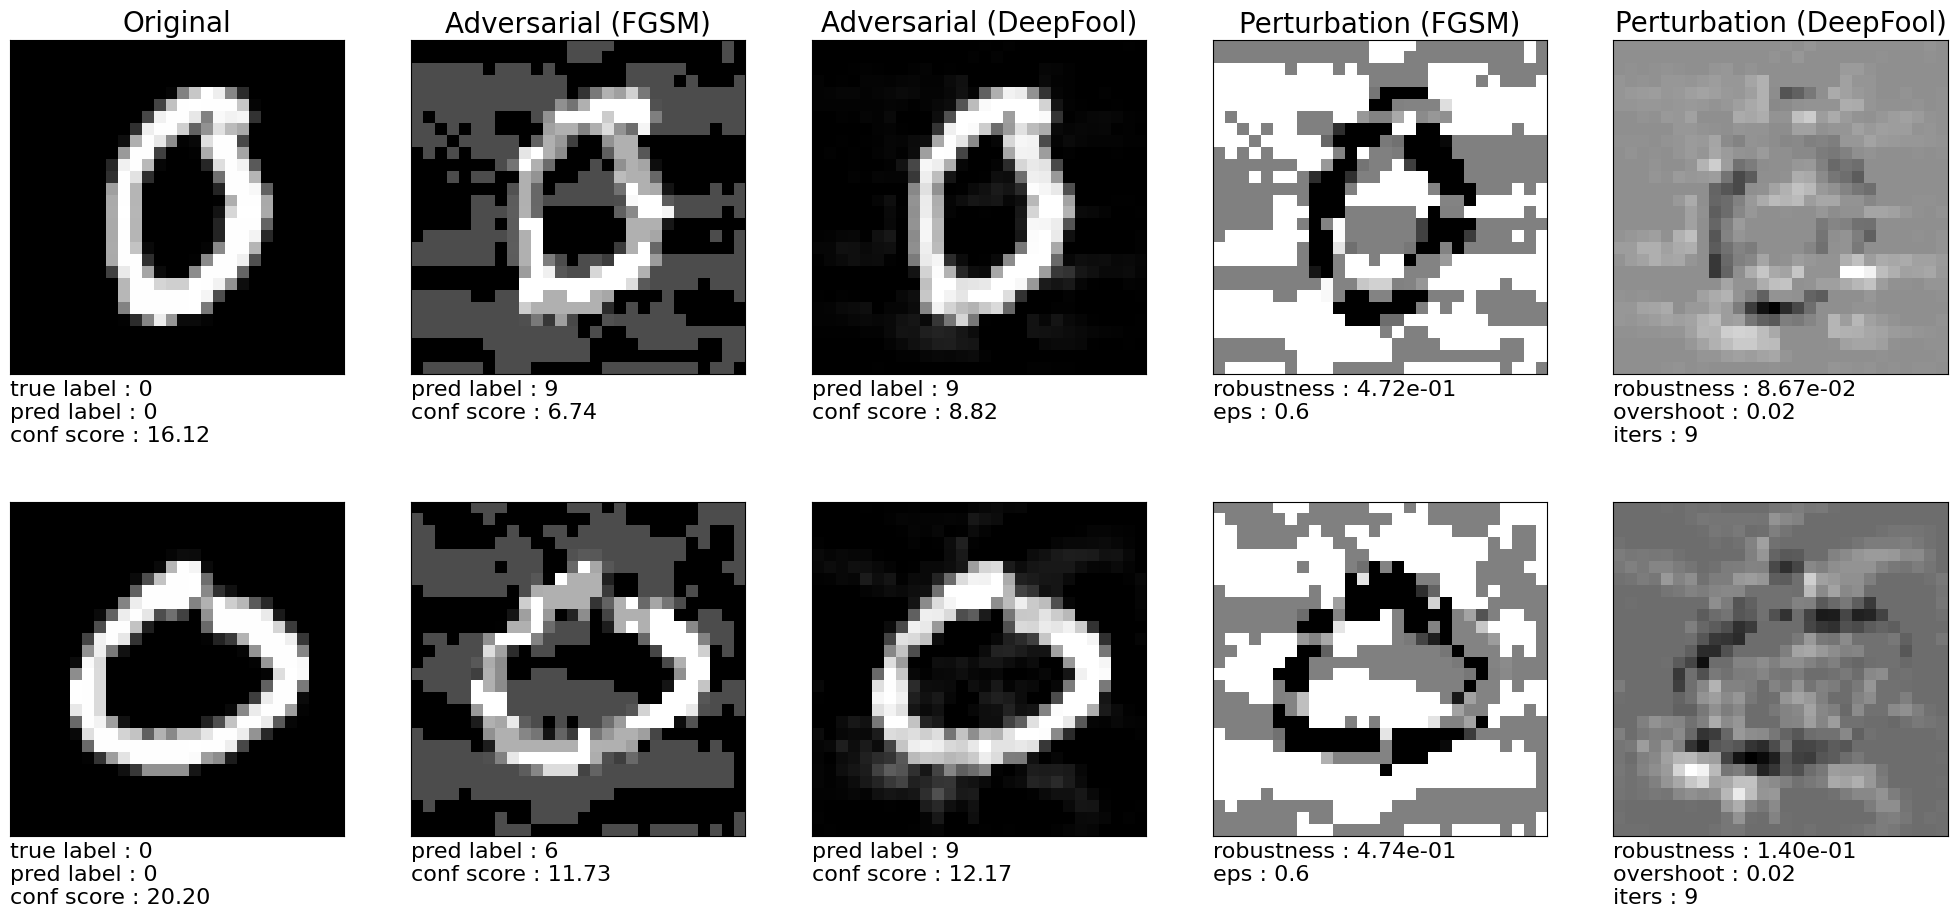

In [ ]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-34-0c8edbb85ce8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

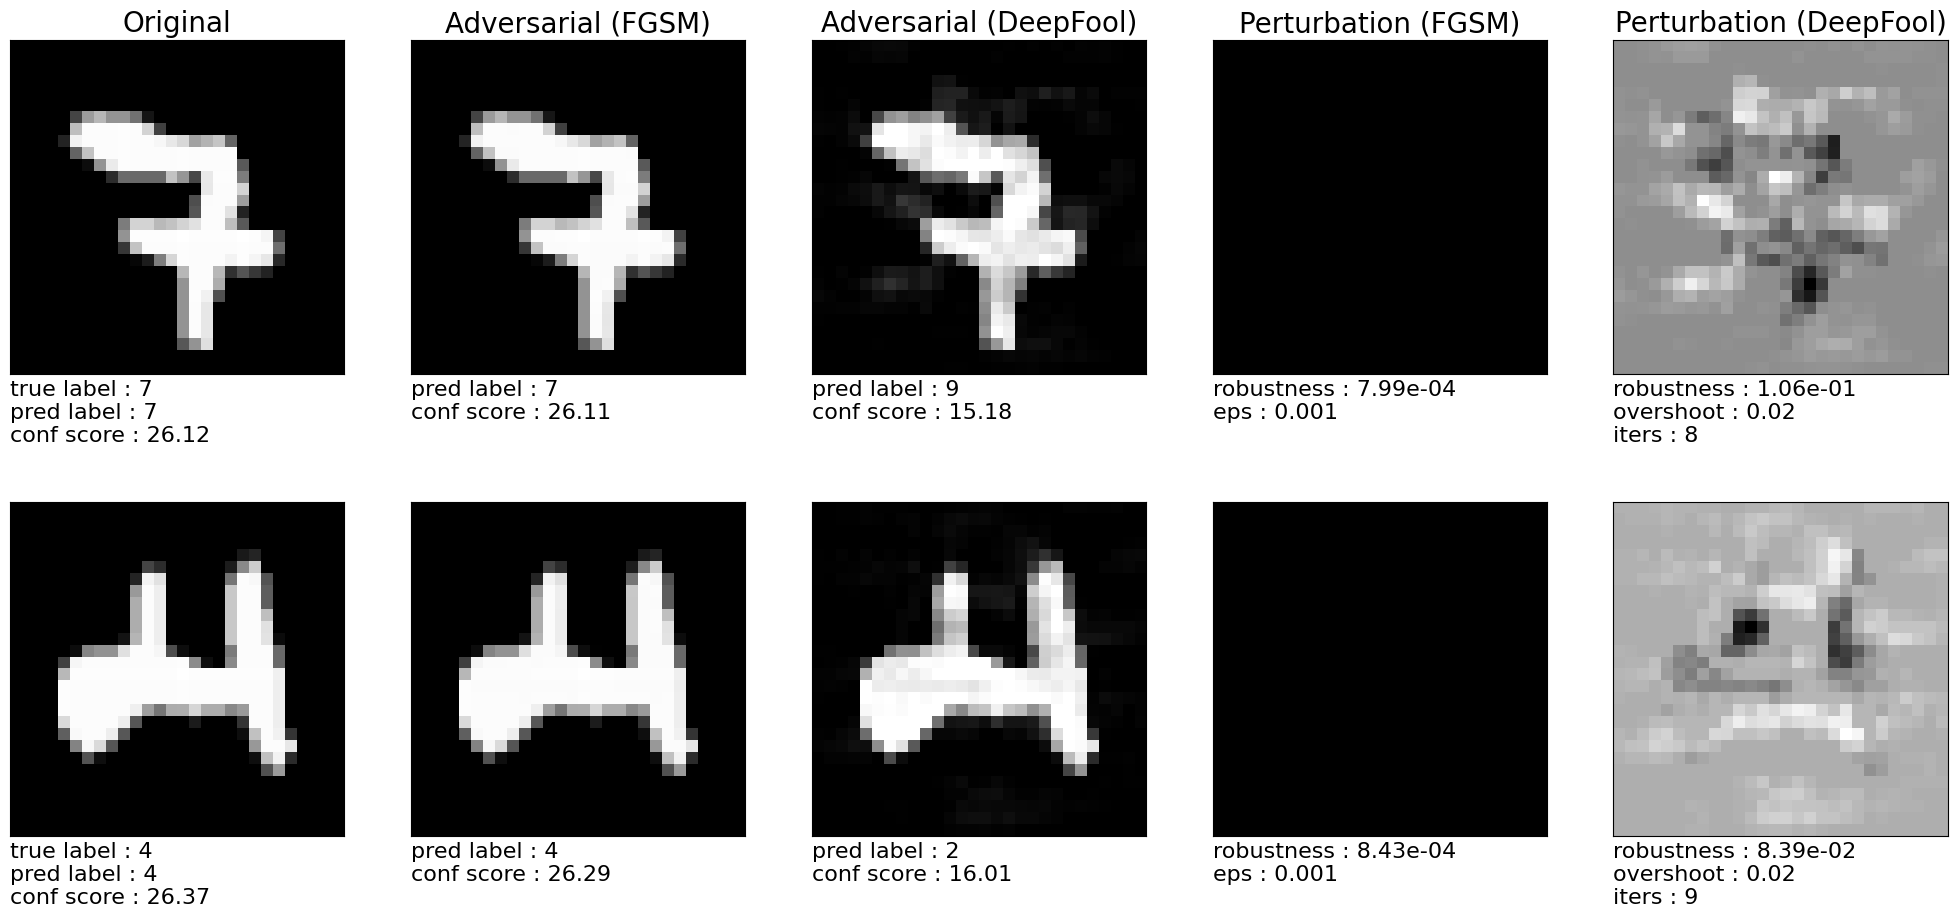

In [ ]:
fgsm_eps = 0.001
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-35-59a79bba30ee>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


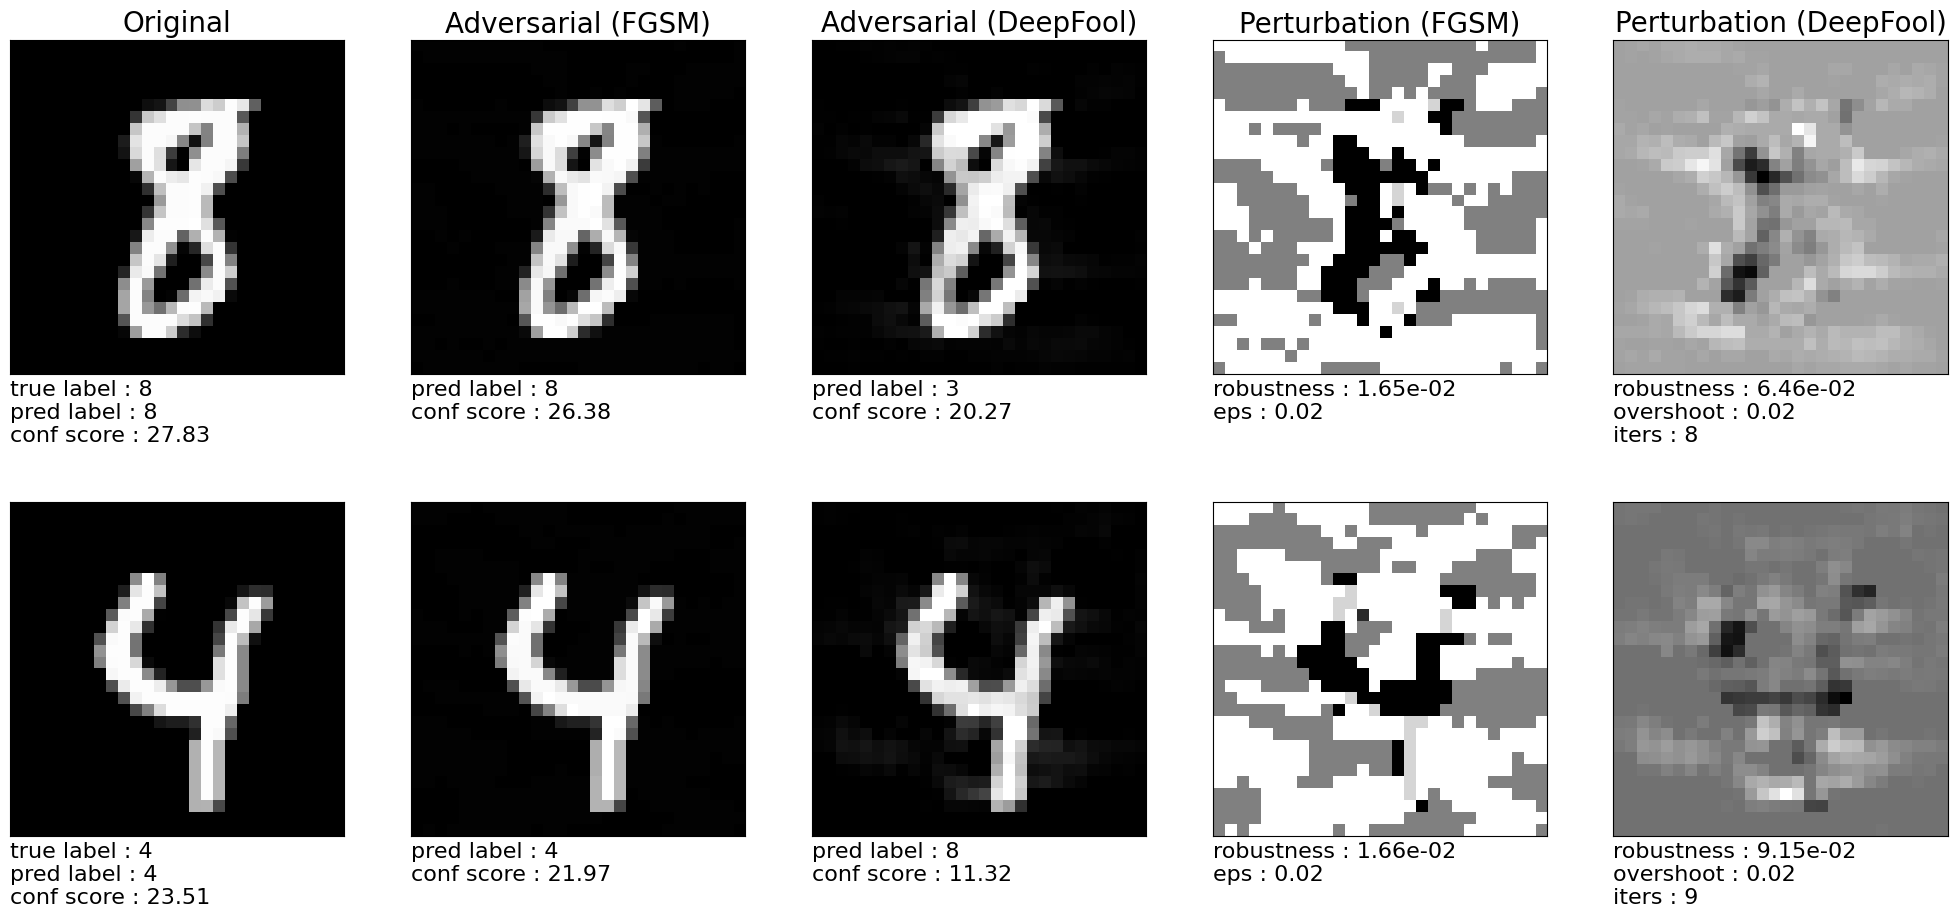

In [ ]:
fgsm_eps = 0.02
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-36-de9a8378cd3b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


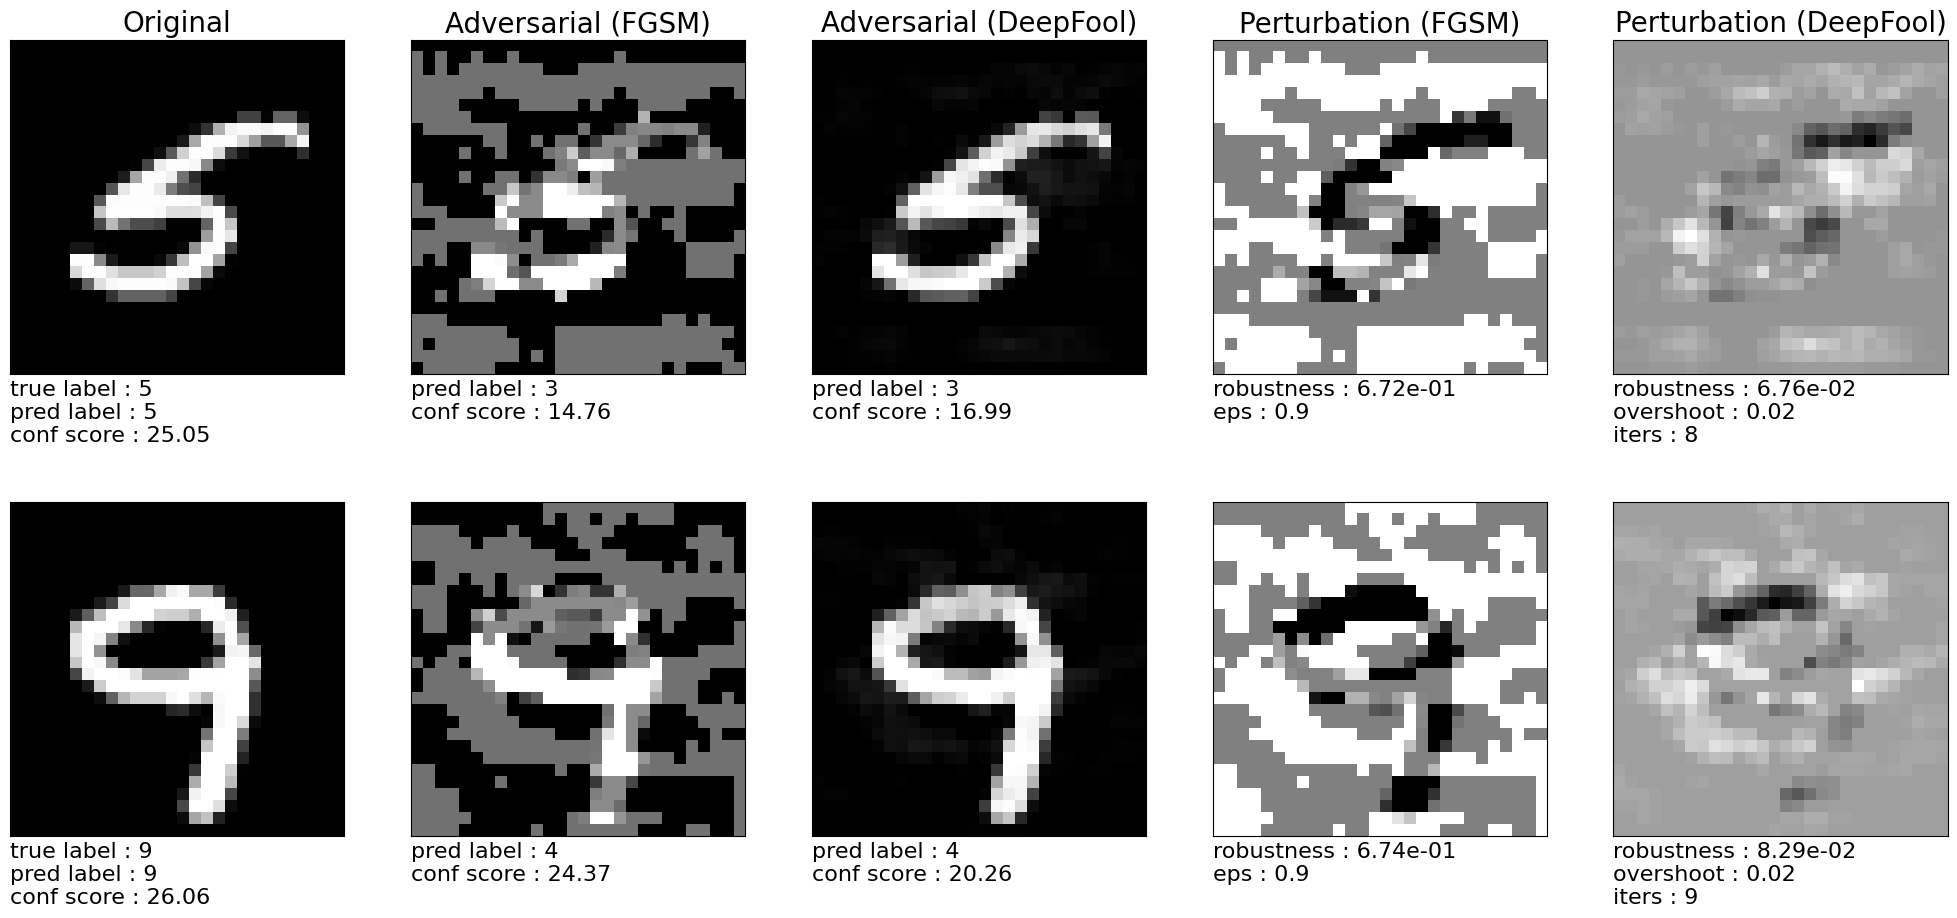

In [ ]:
fgsm_eps = 0.9
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-37-85d914ef4978>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


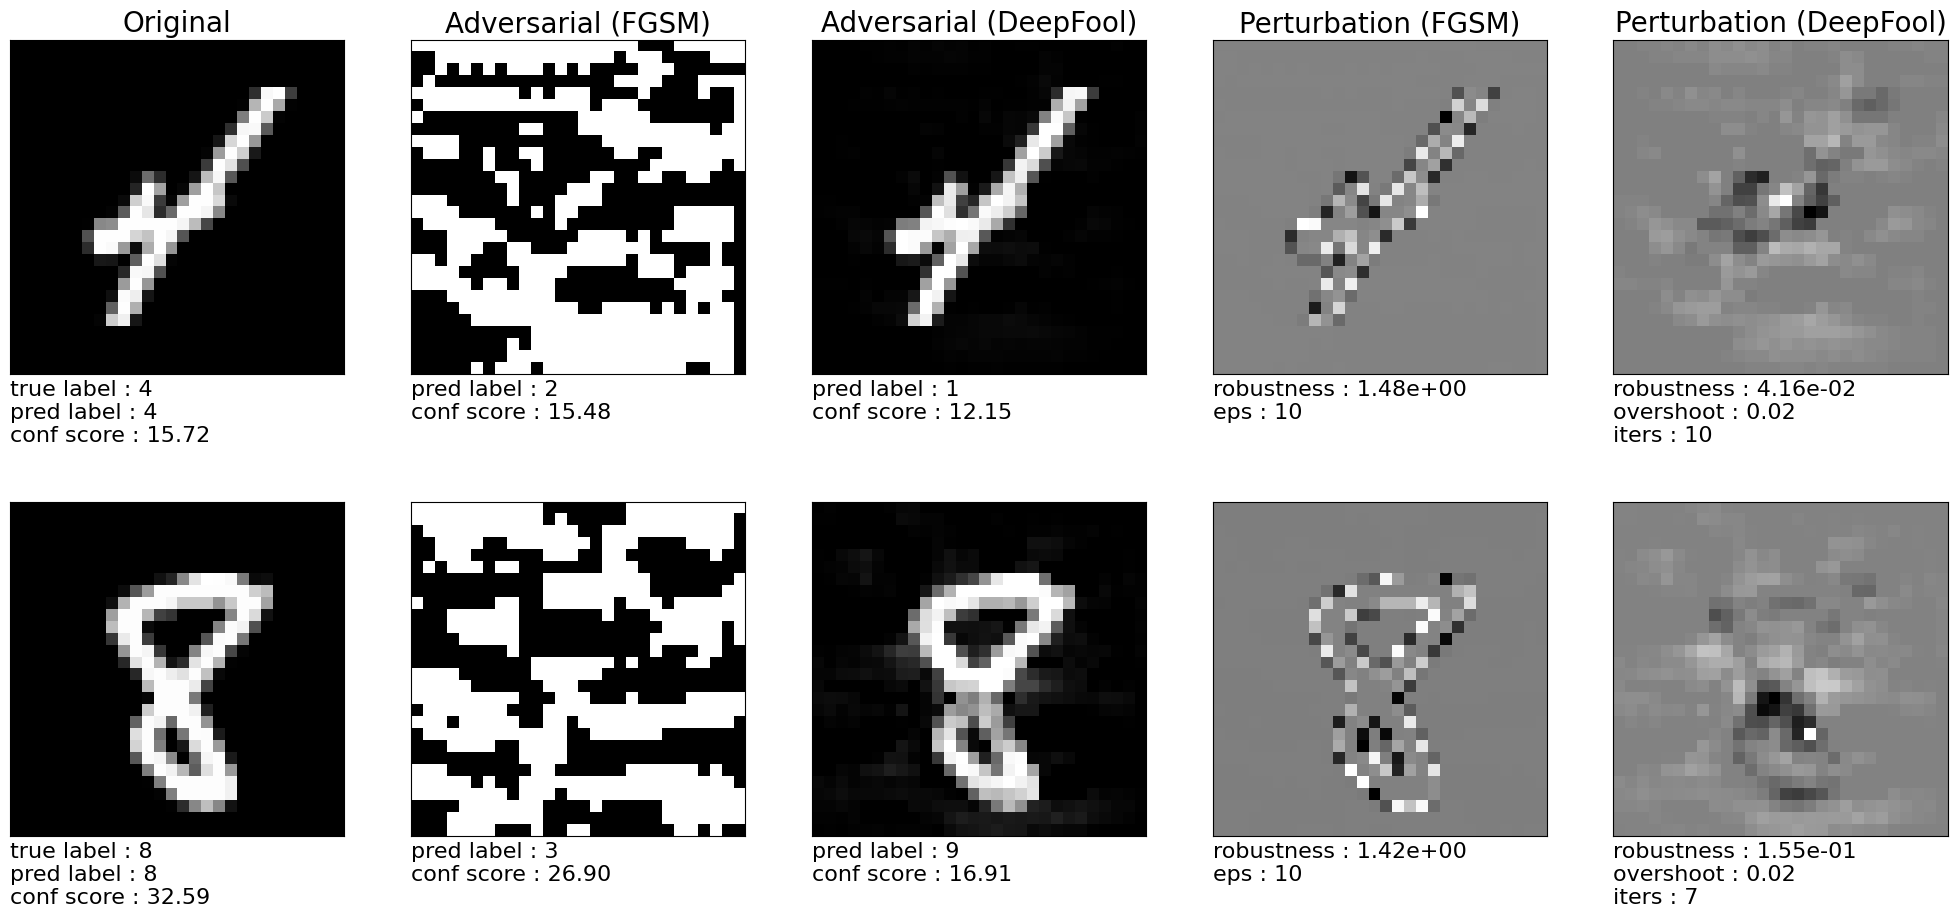

In [ ]:
fgsm_eps = 10
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-39-fb3c4b839937>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


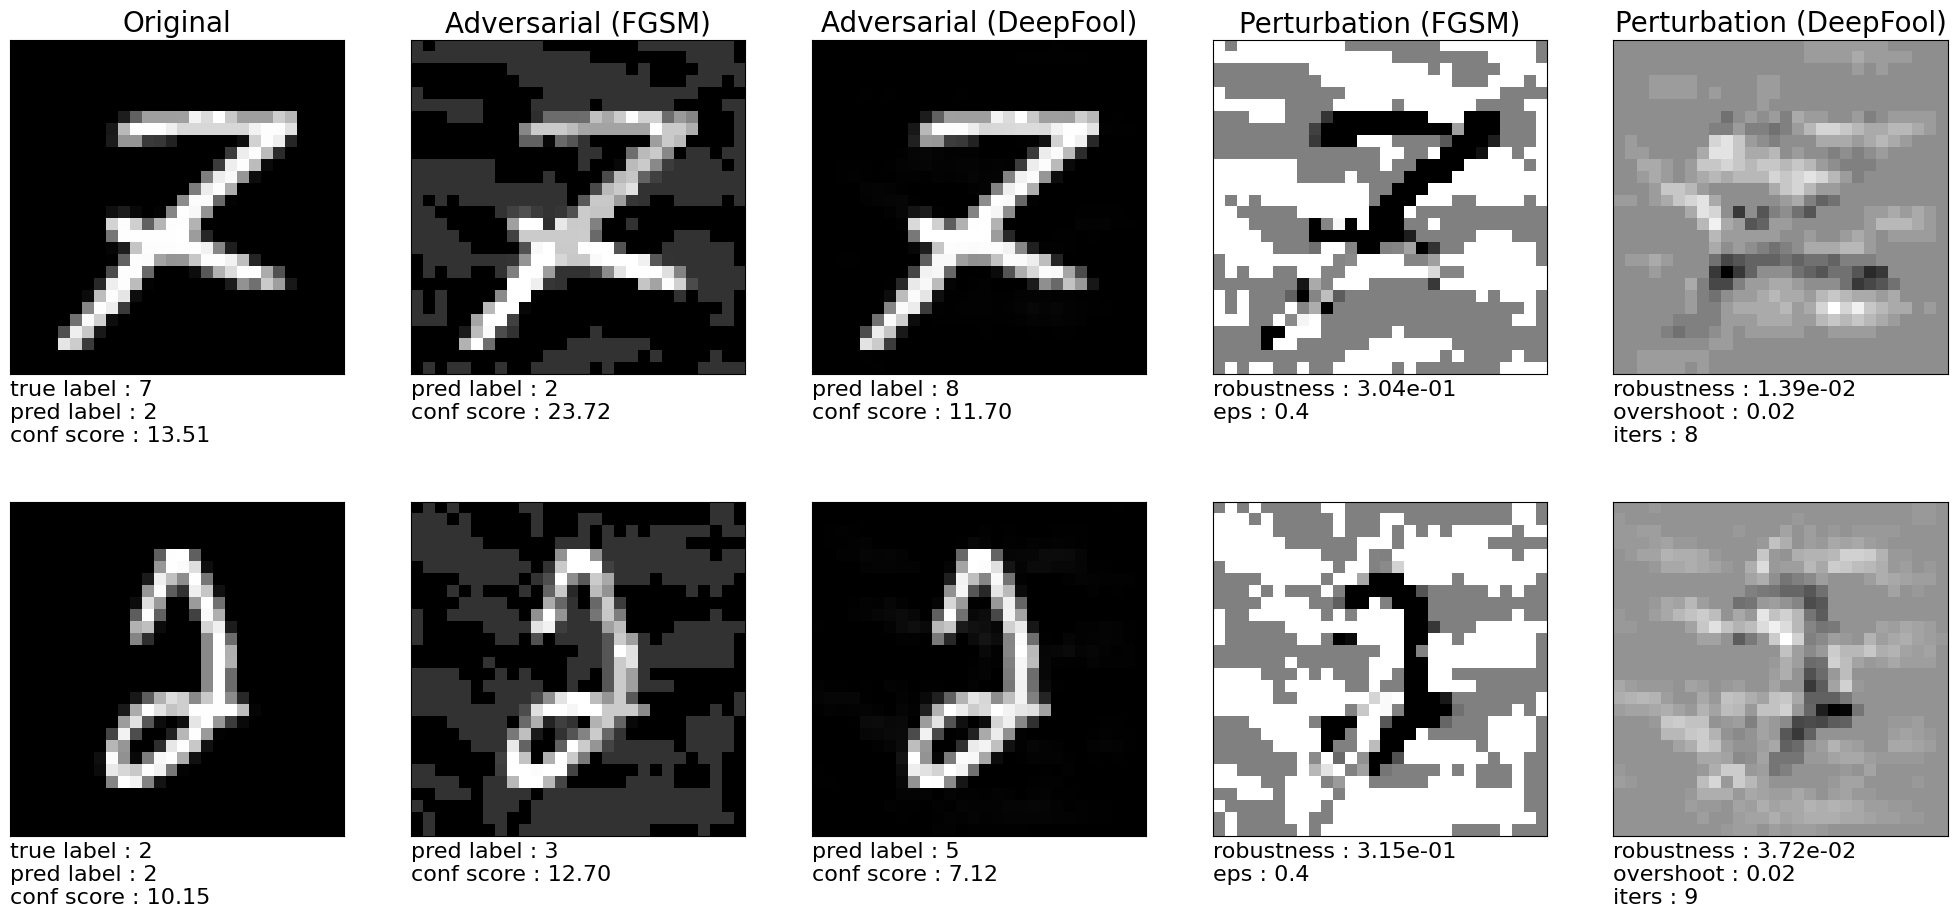

In [ ]:
fgsm_eps = 0.4
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-15-f2c0eac43d73>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


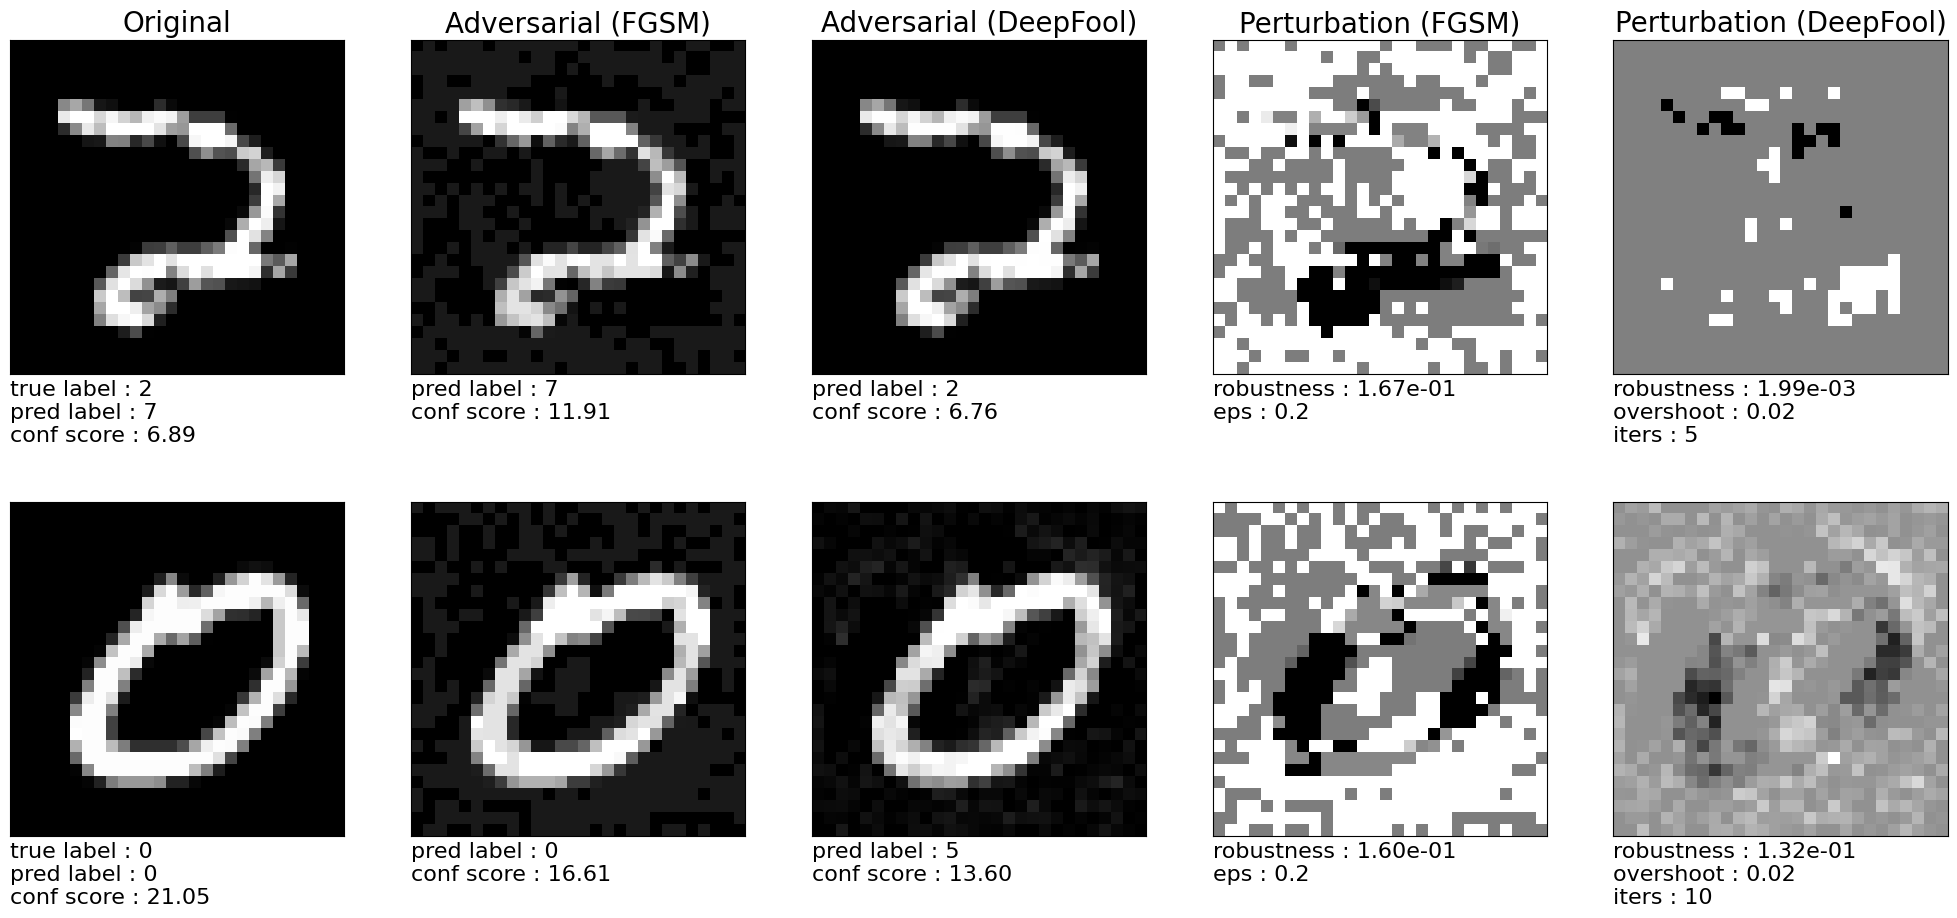

In [ ]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-21-02cbf900d283>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

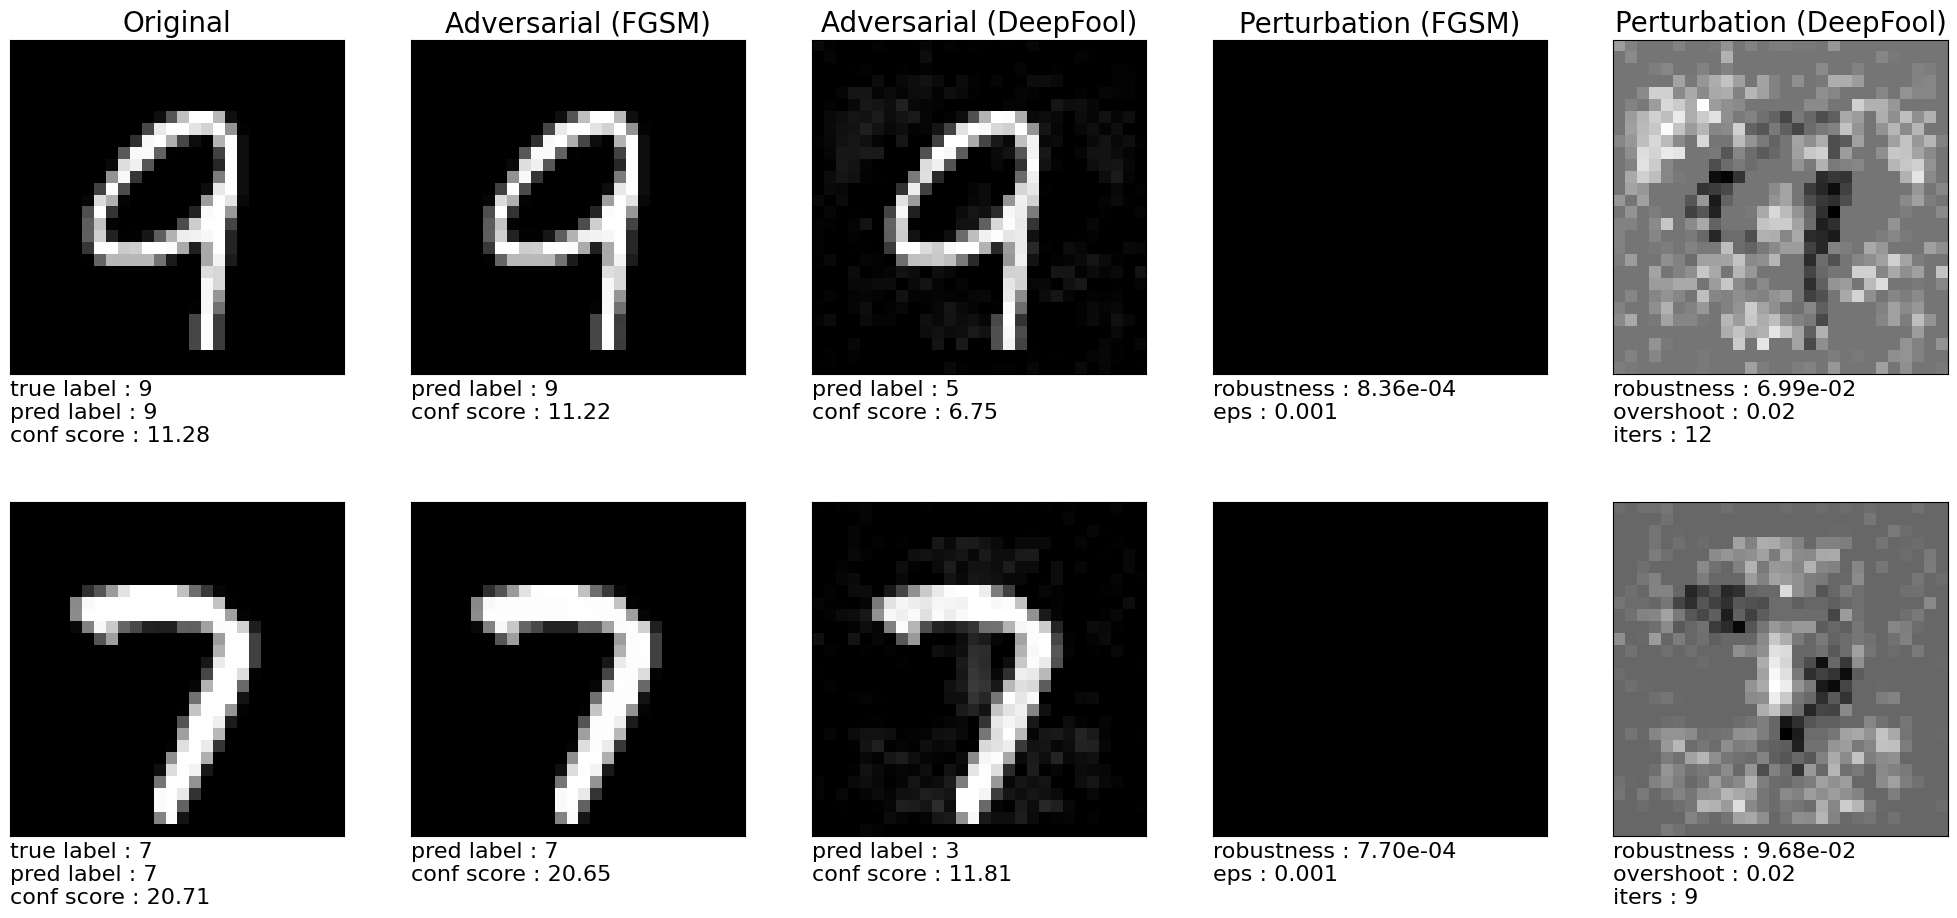

In [ ]:
fgsm_eps = 0.001
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-22-8ccf354fc3db>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


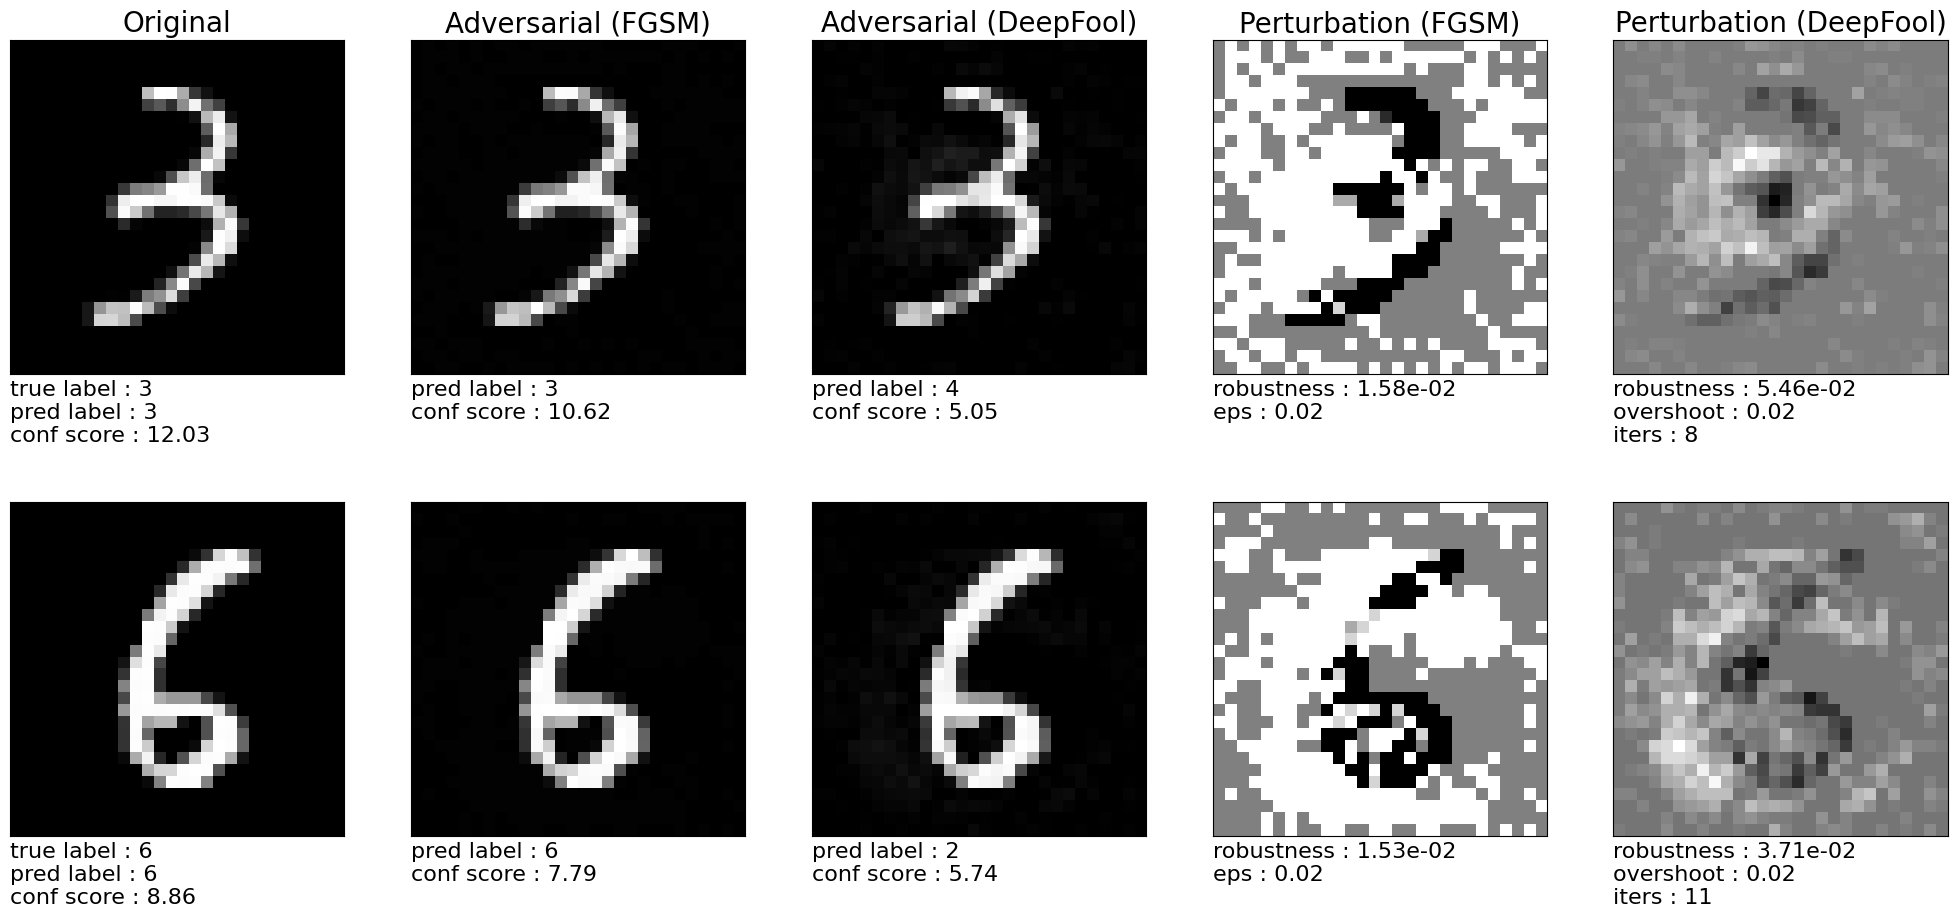

In [ ]:
fgsm_eps = 0.02
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-23-f44b5cf3d8fc>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


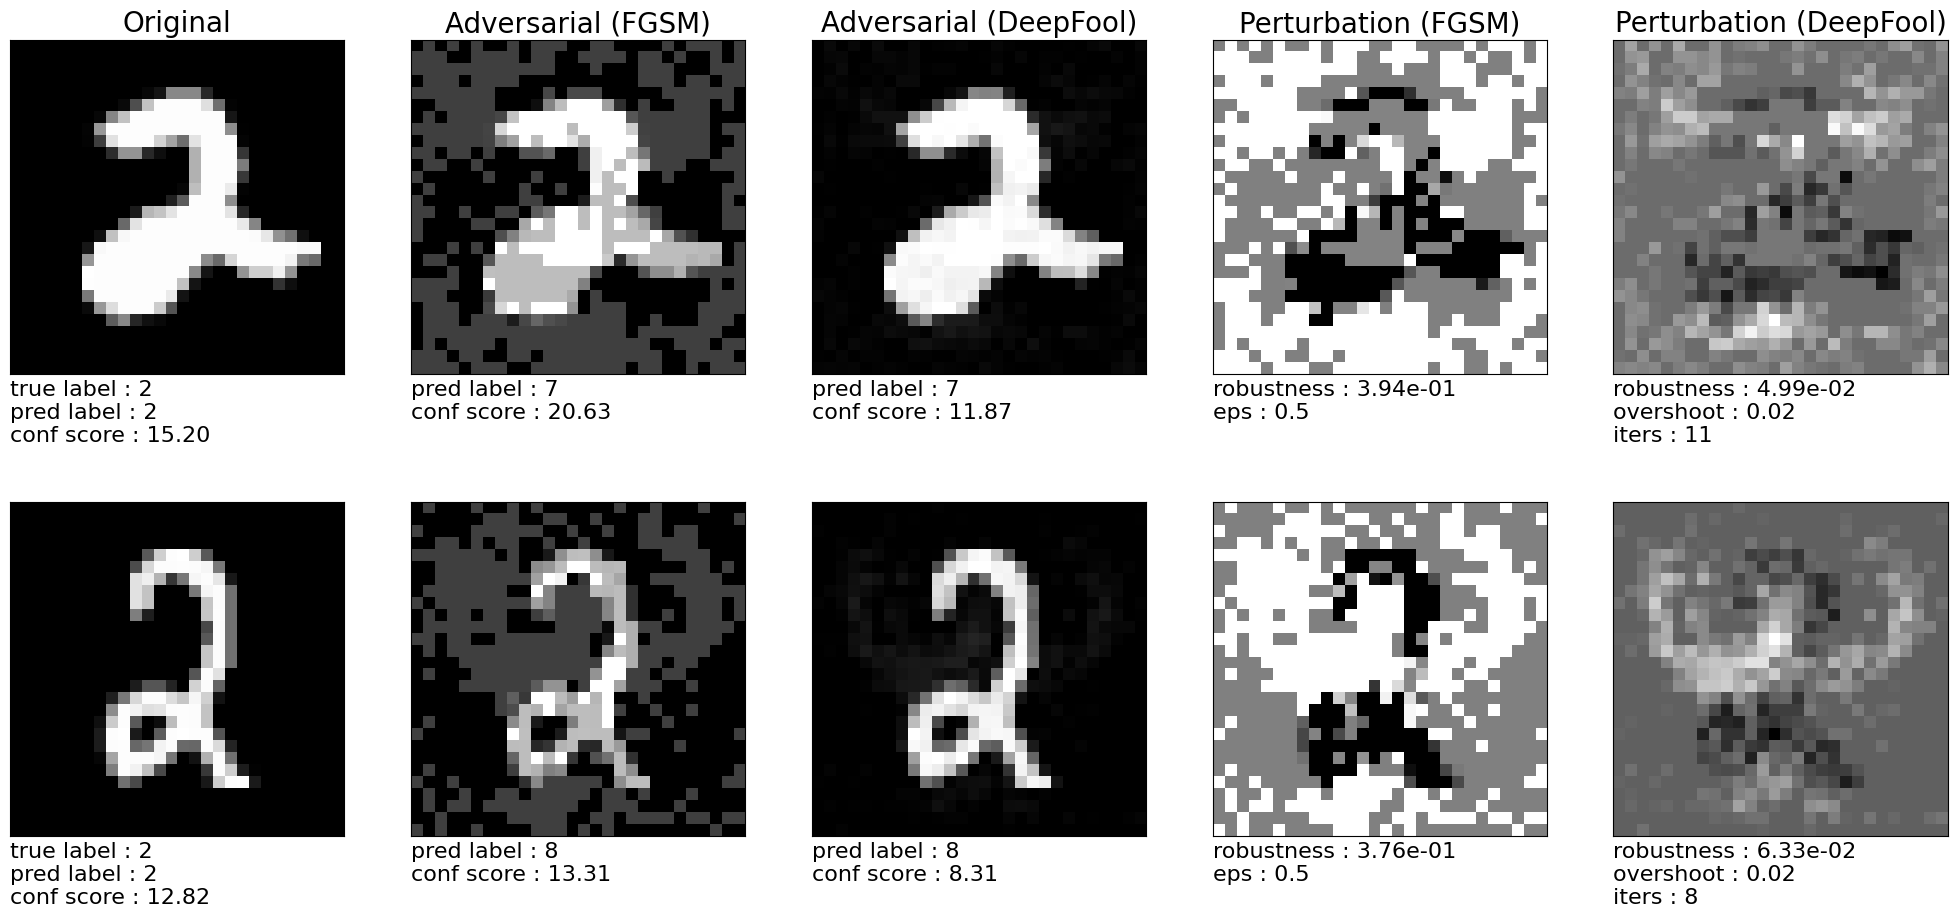

In [ ]:
fgsm_eps = 0.5
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-24-bbb88567c005>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


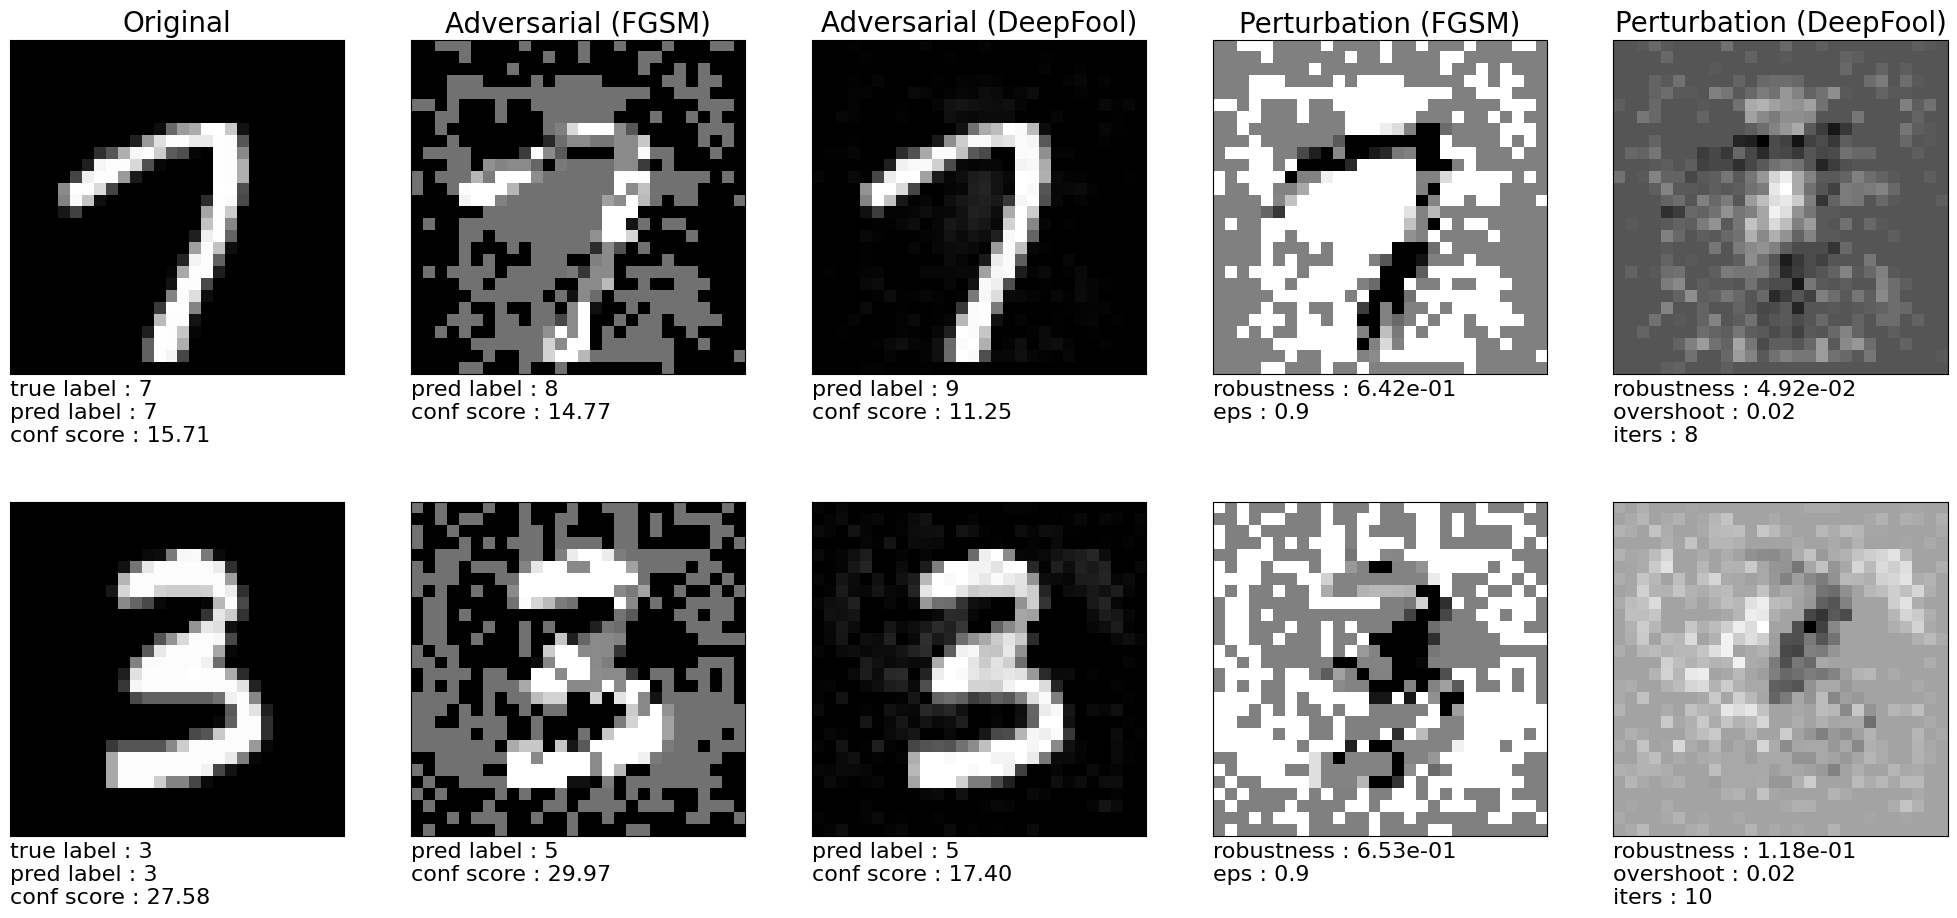

In [ ]:
fgsm_eps = 0.9
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-25-15a175a40bce>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


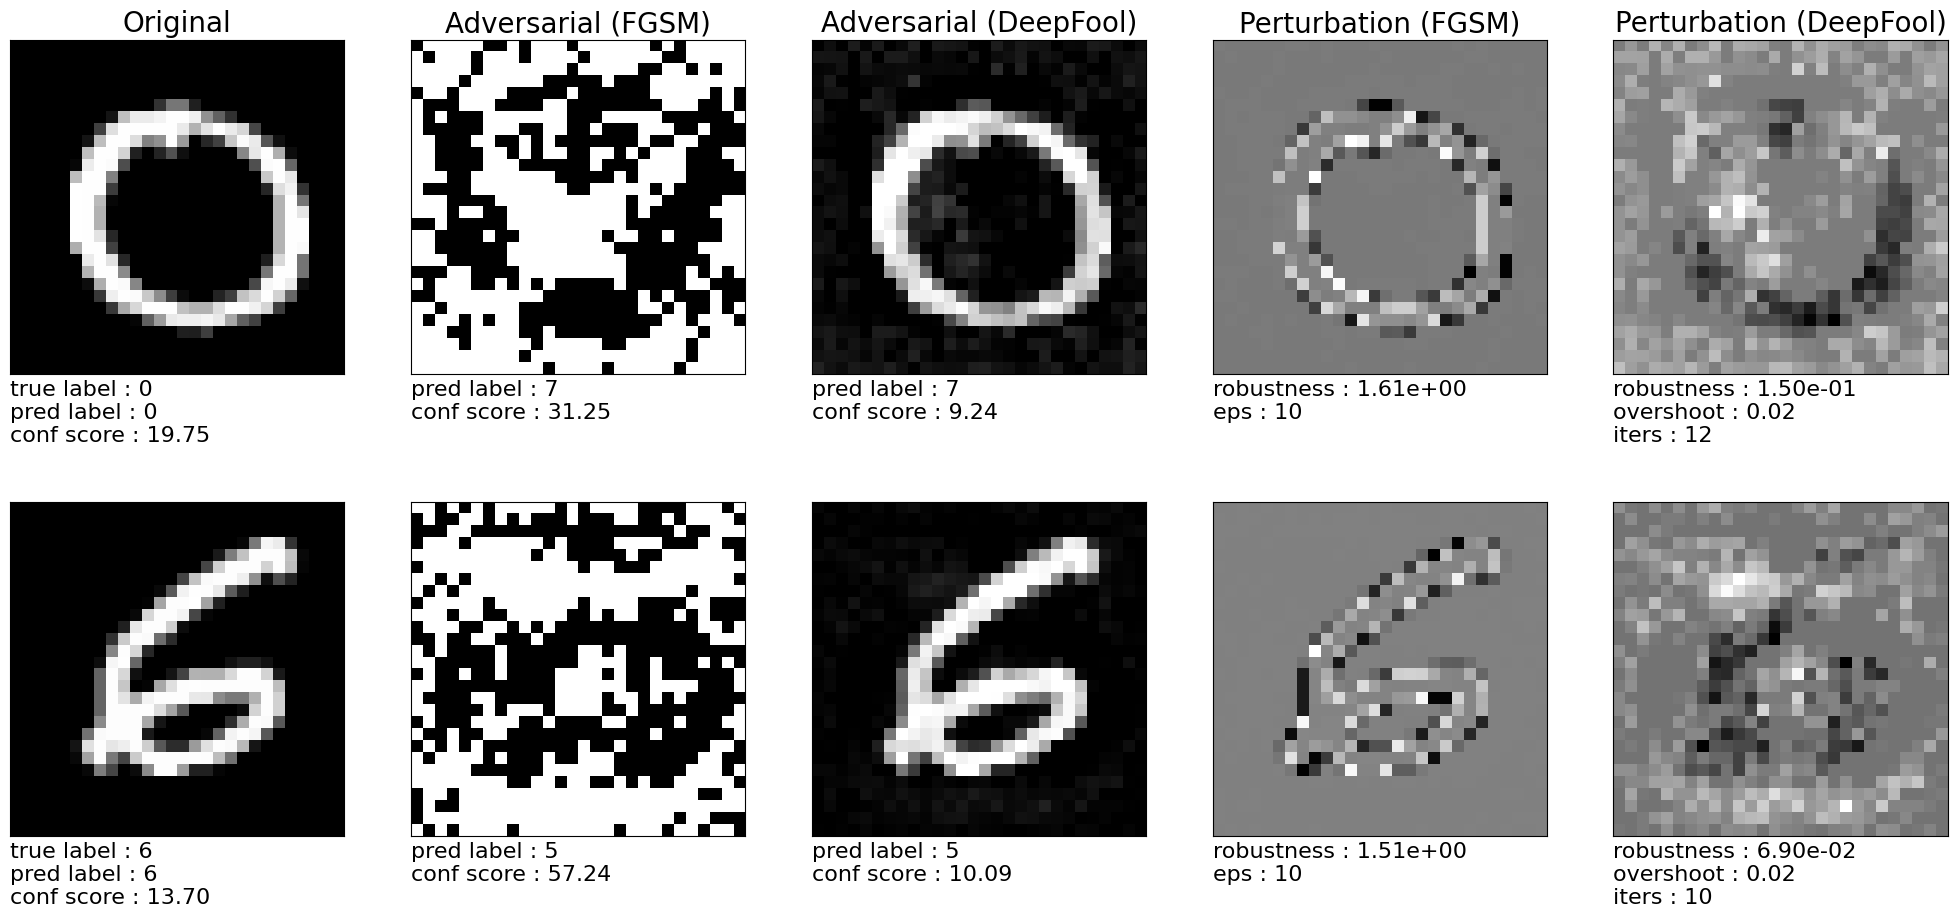

In [ ]:
fgsm_eps = 10
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-31-07fdd163b8c8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

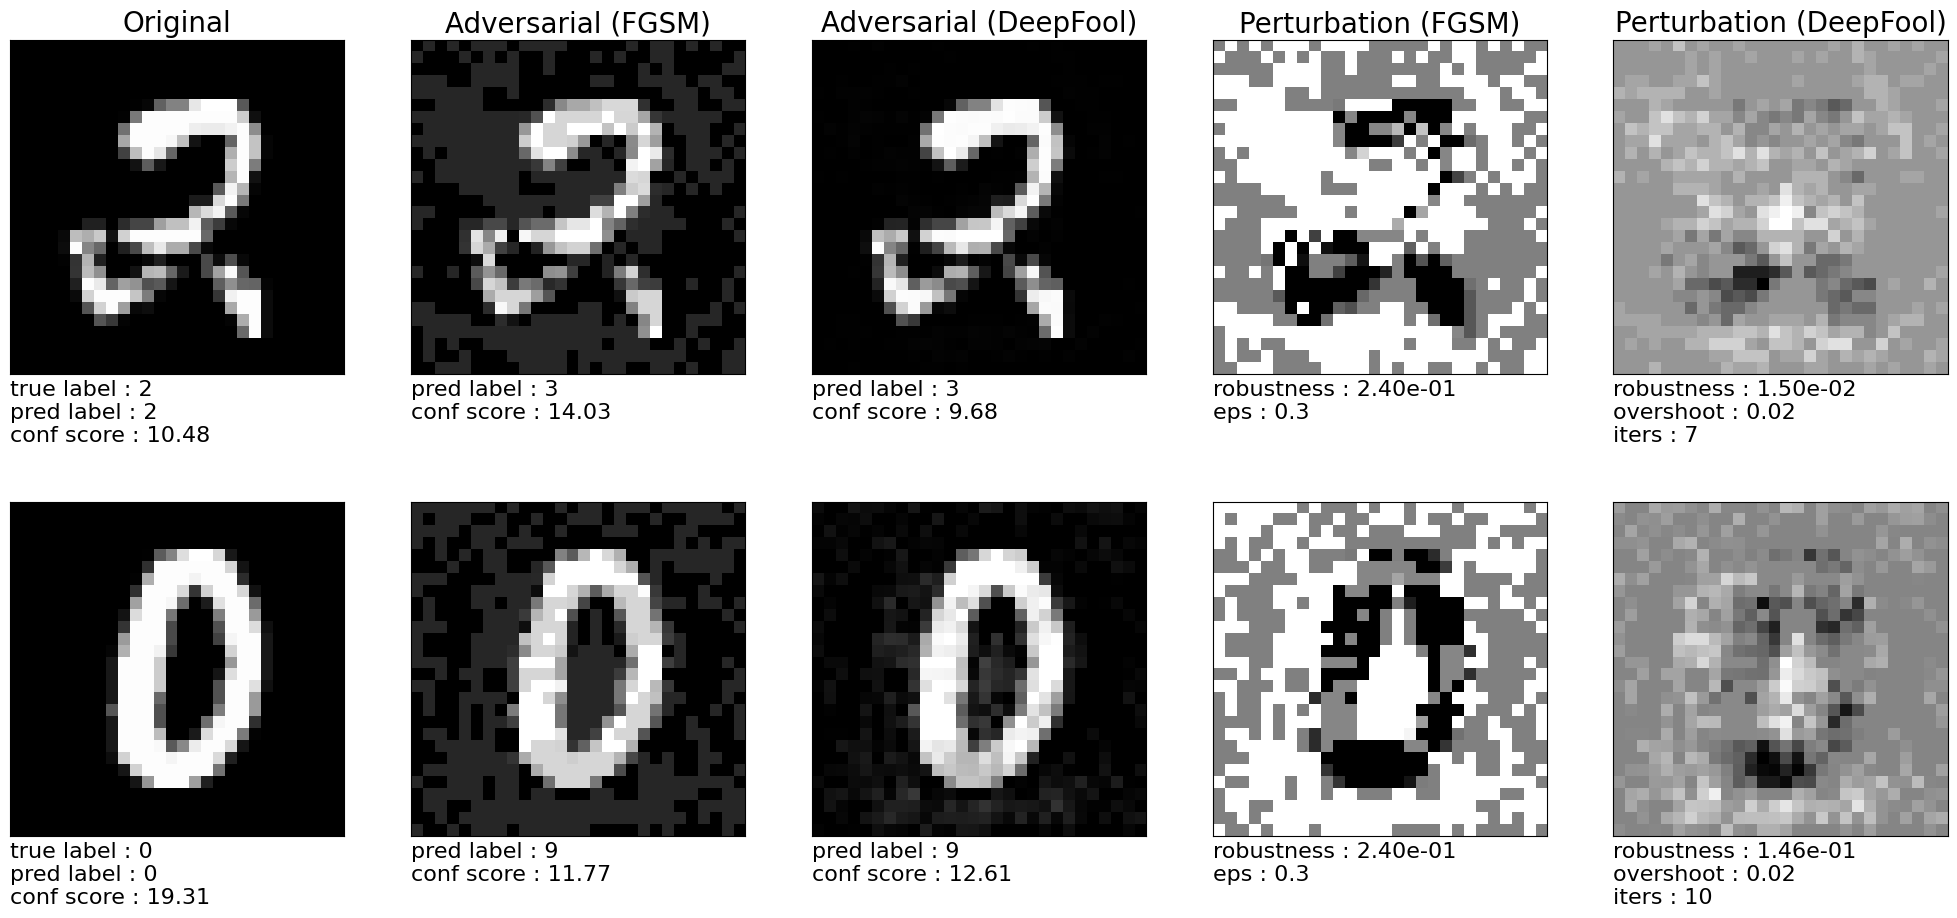

In [ ]:
fgsm_eps = 0.3
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv,
               mnist_min, mnist_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-16-0af5ebefba34>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


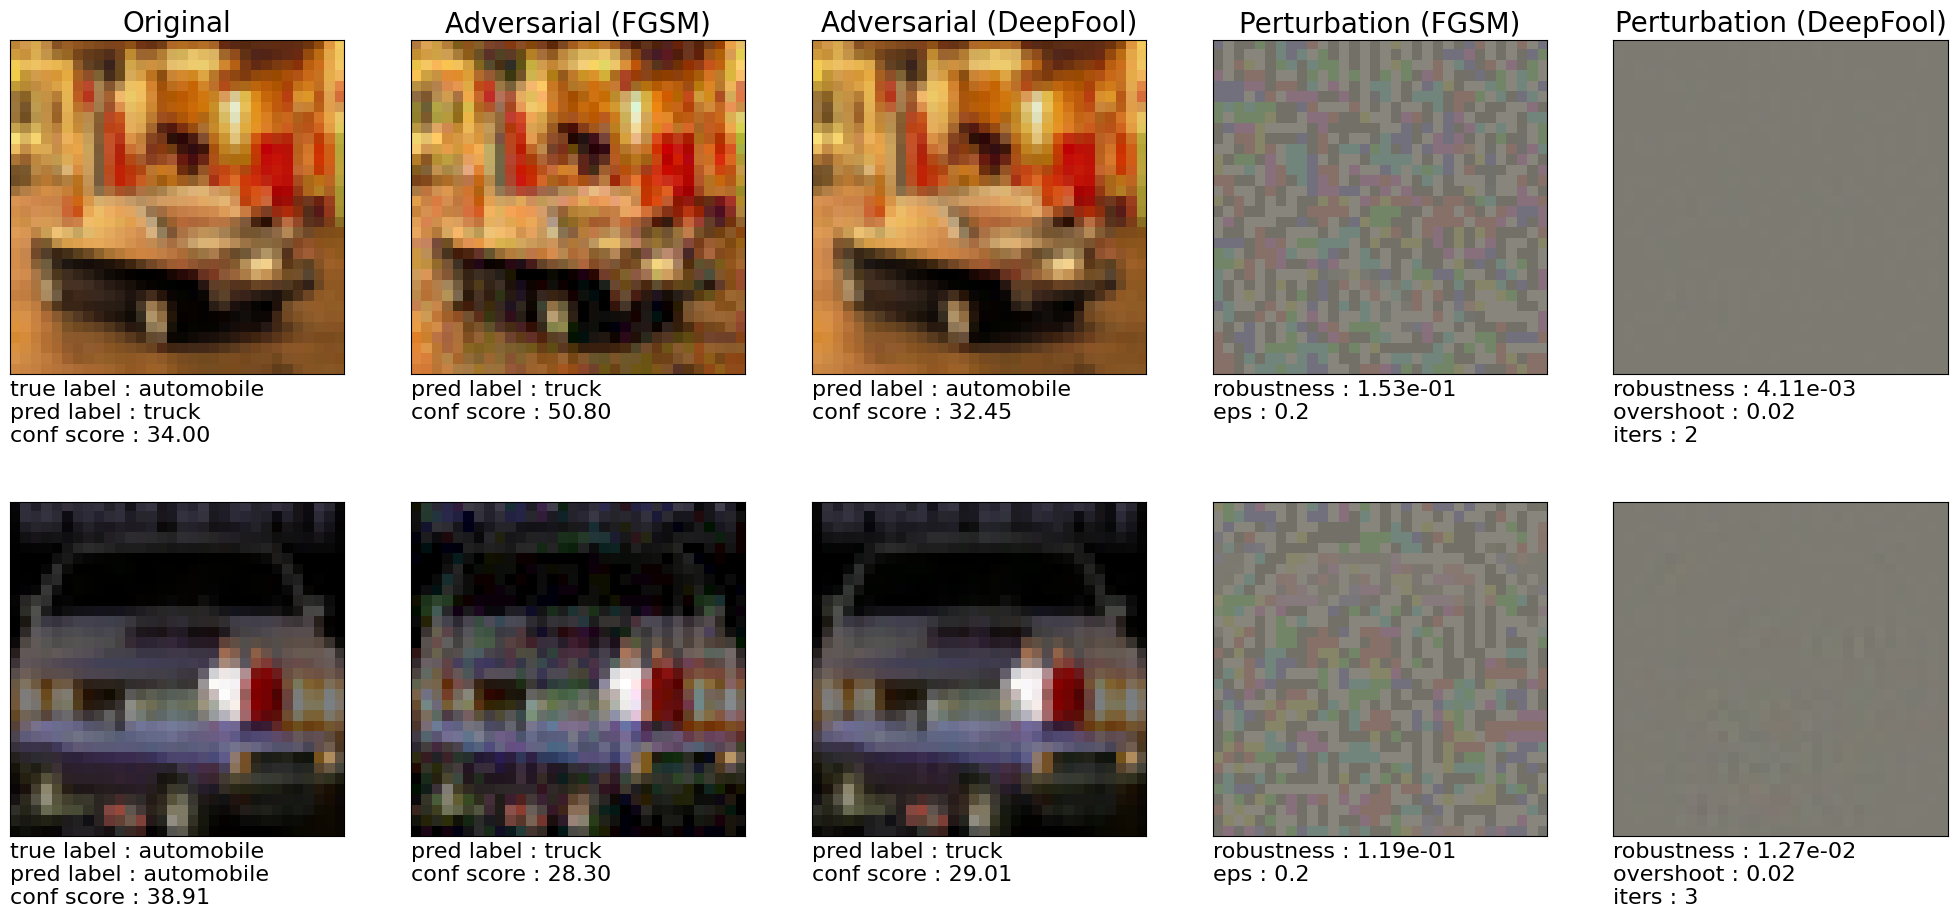

In [ ]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-41-64c0ae1ccd6e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


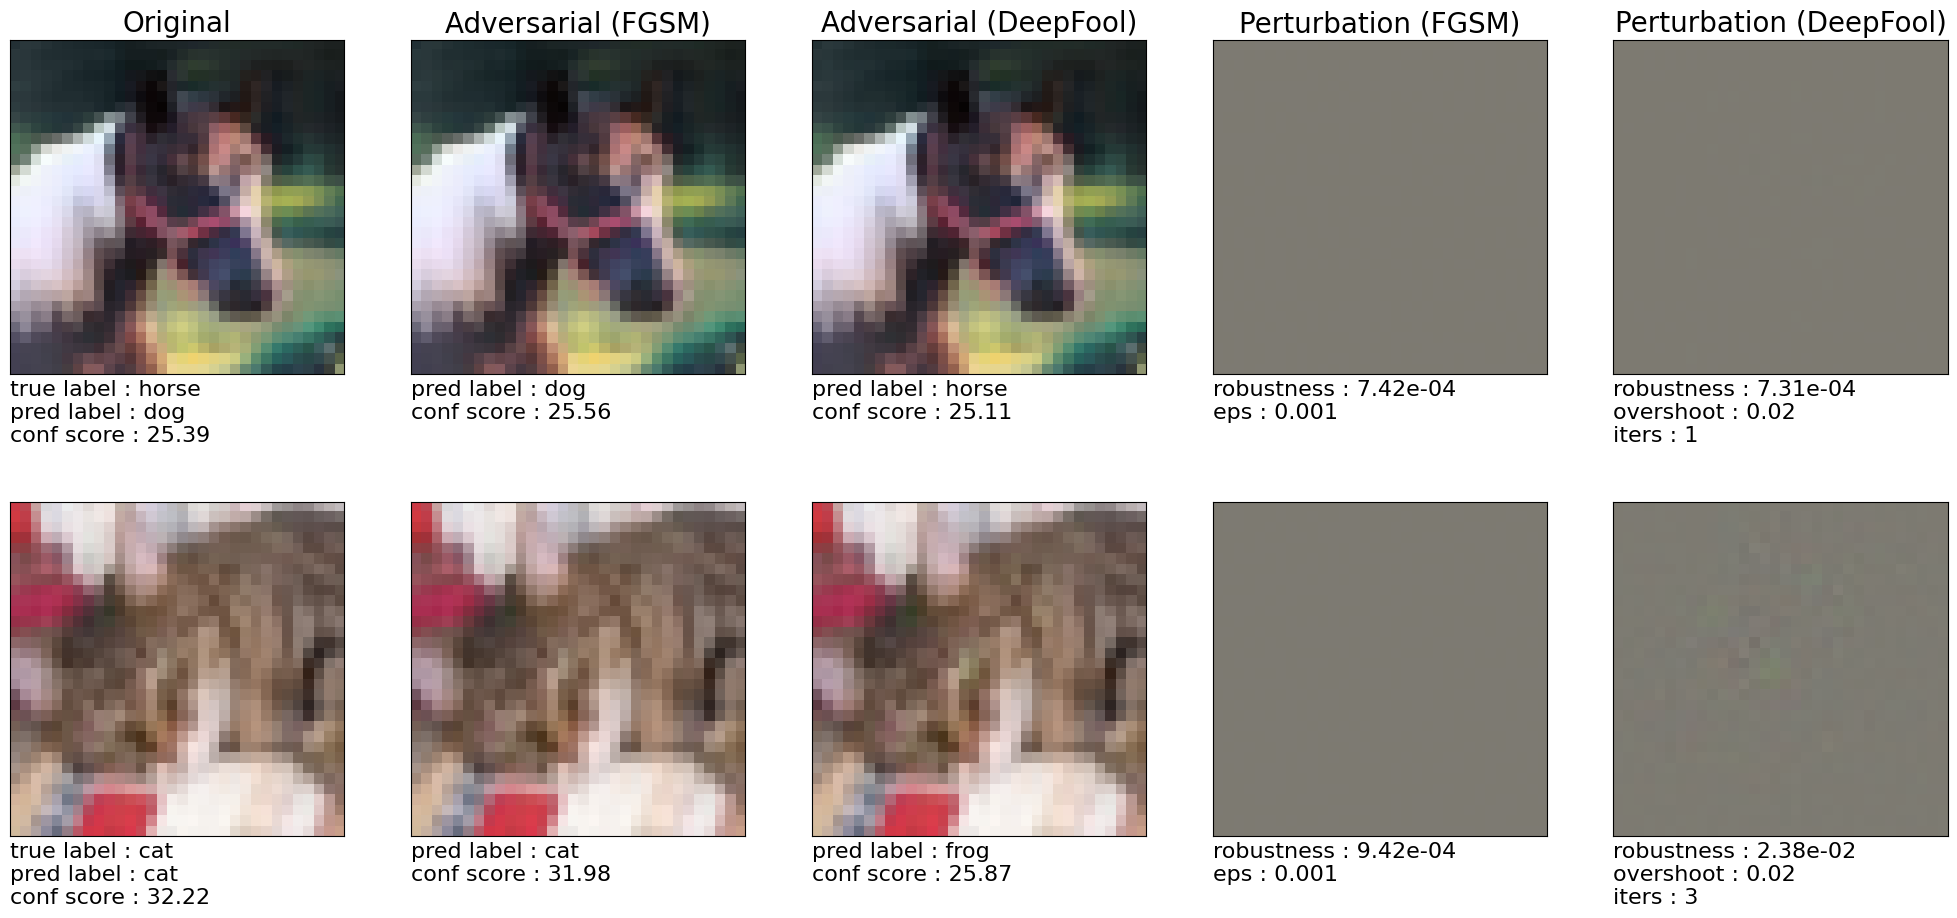

In [ ]:
fgsm_eps = 0.001
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-42-06a0ee636a2a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


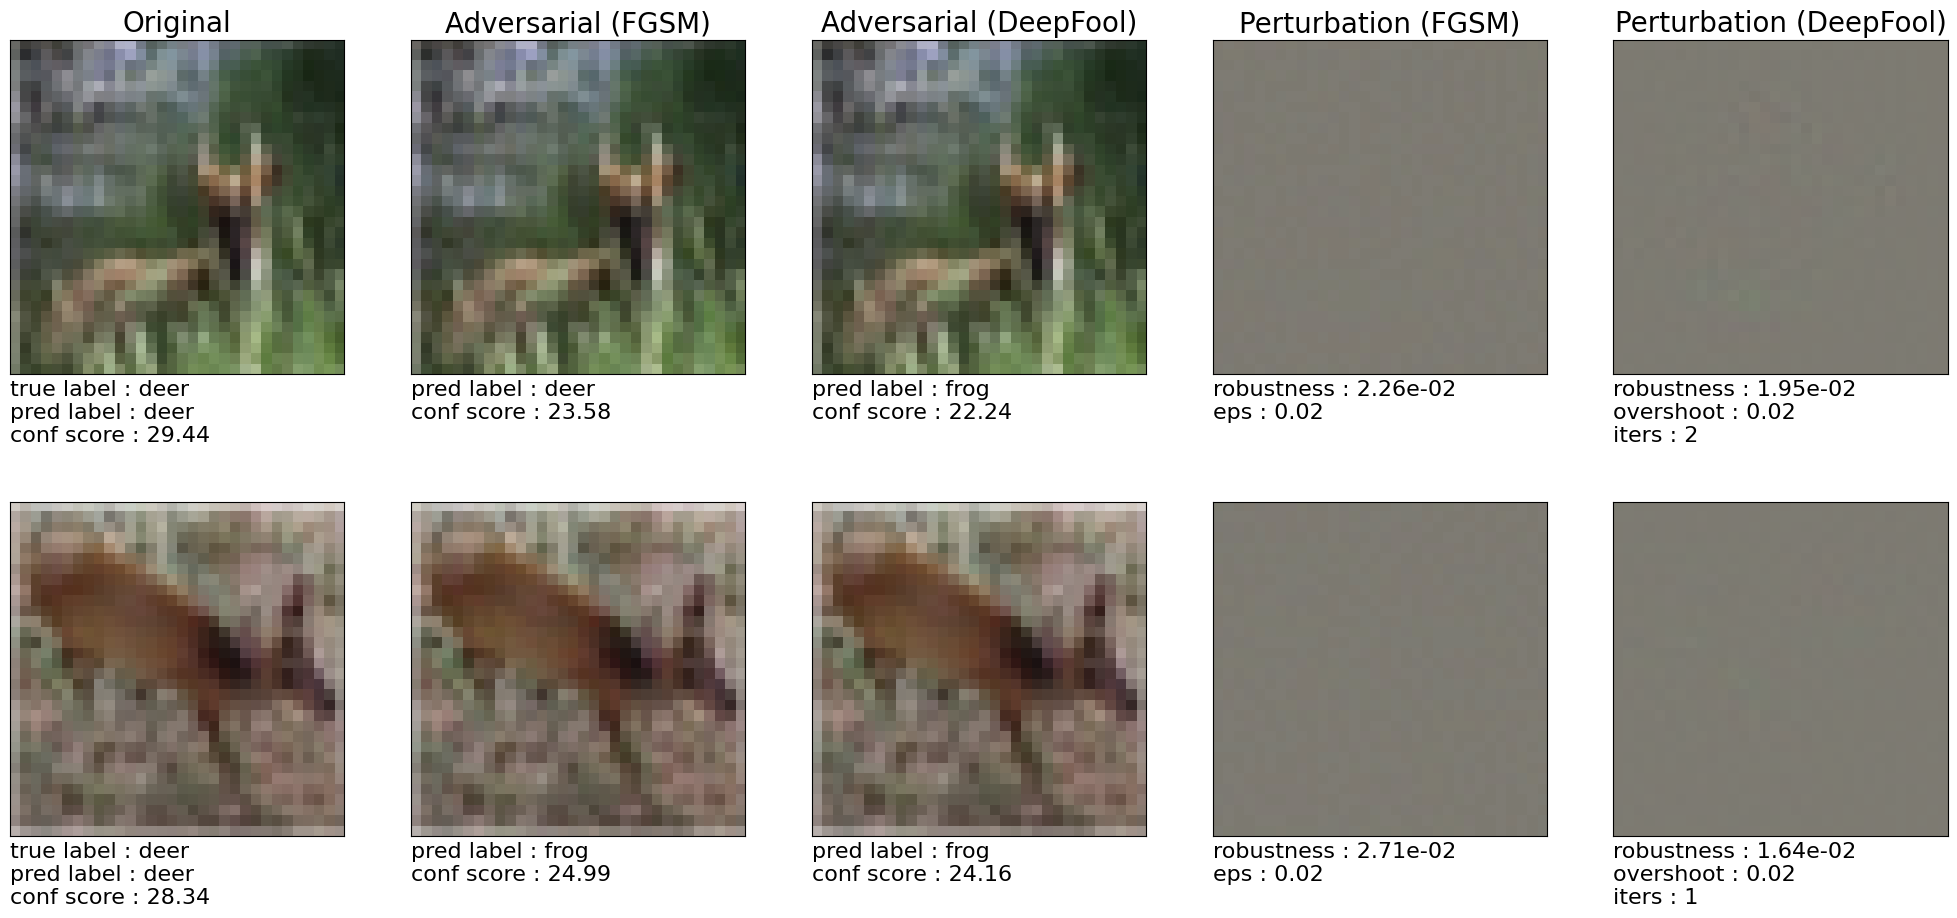

In [ ]:
fgsm_eps = 0.02
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-43-b30f13a891e7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


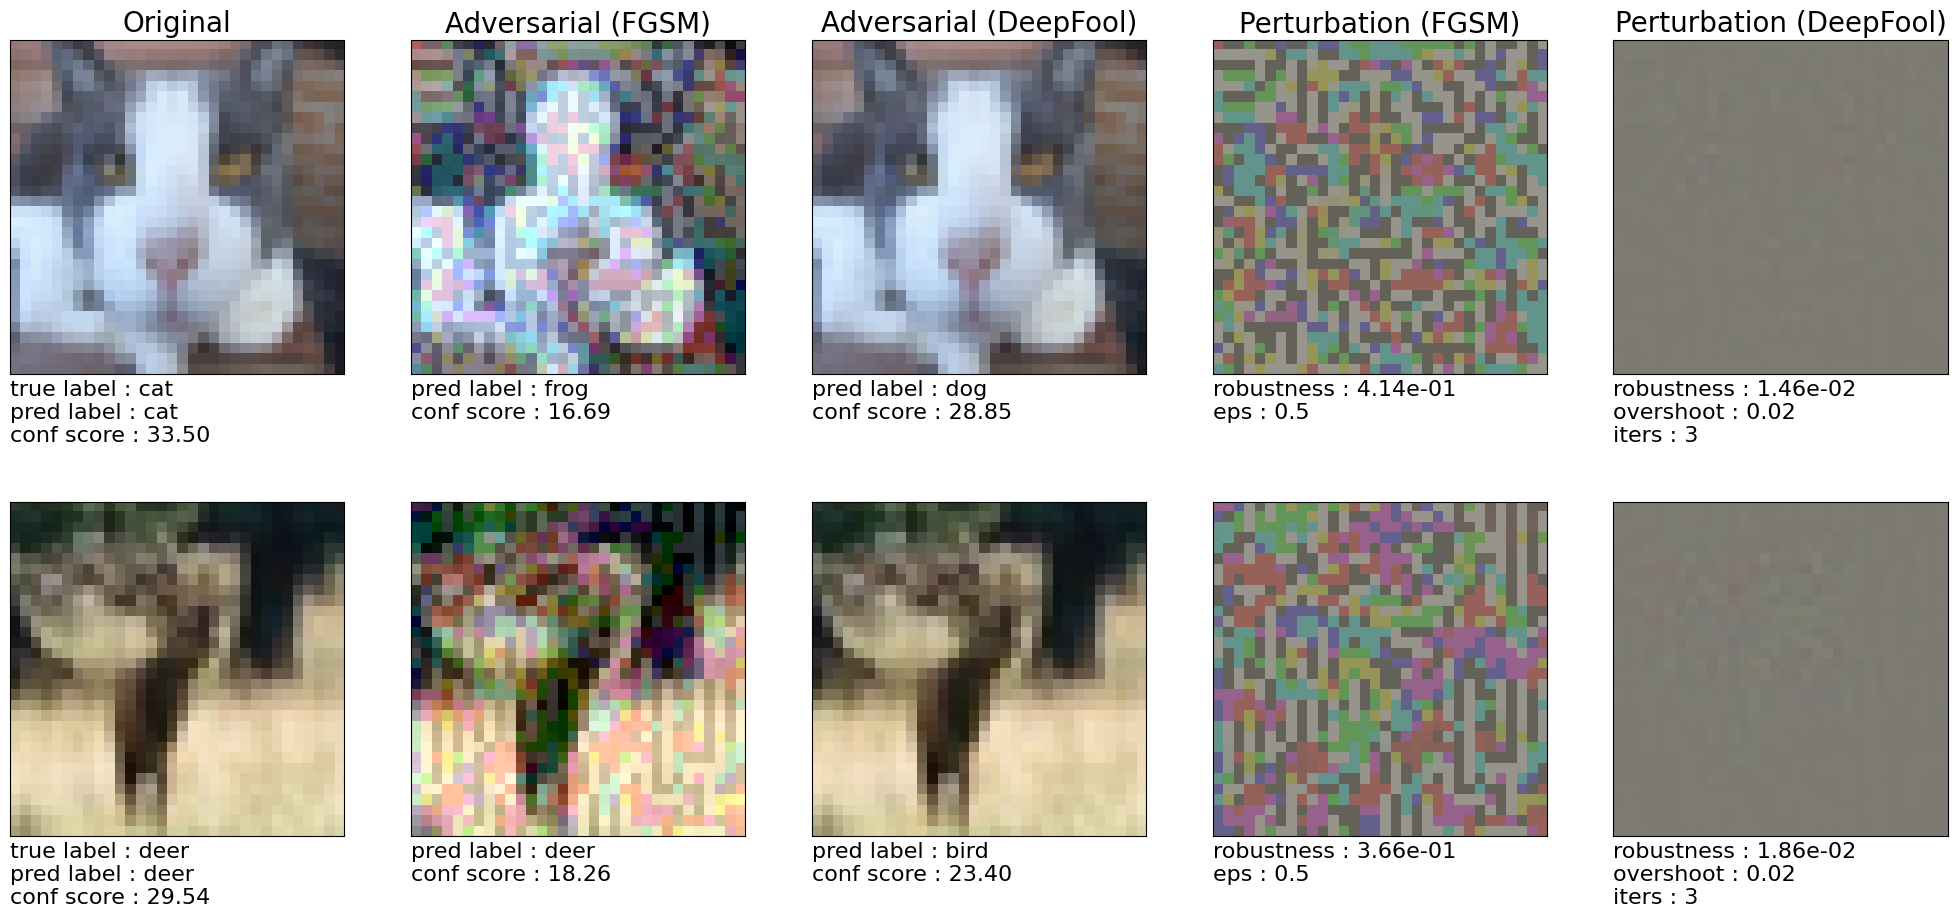

In [ ]:
fgsm_eps = 0.5
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-44-7d8427590144>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

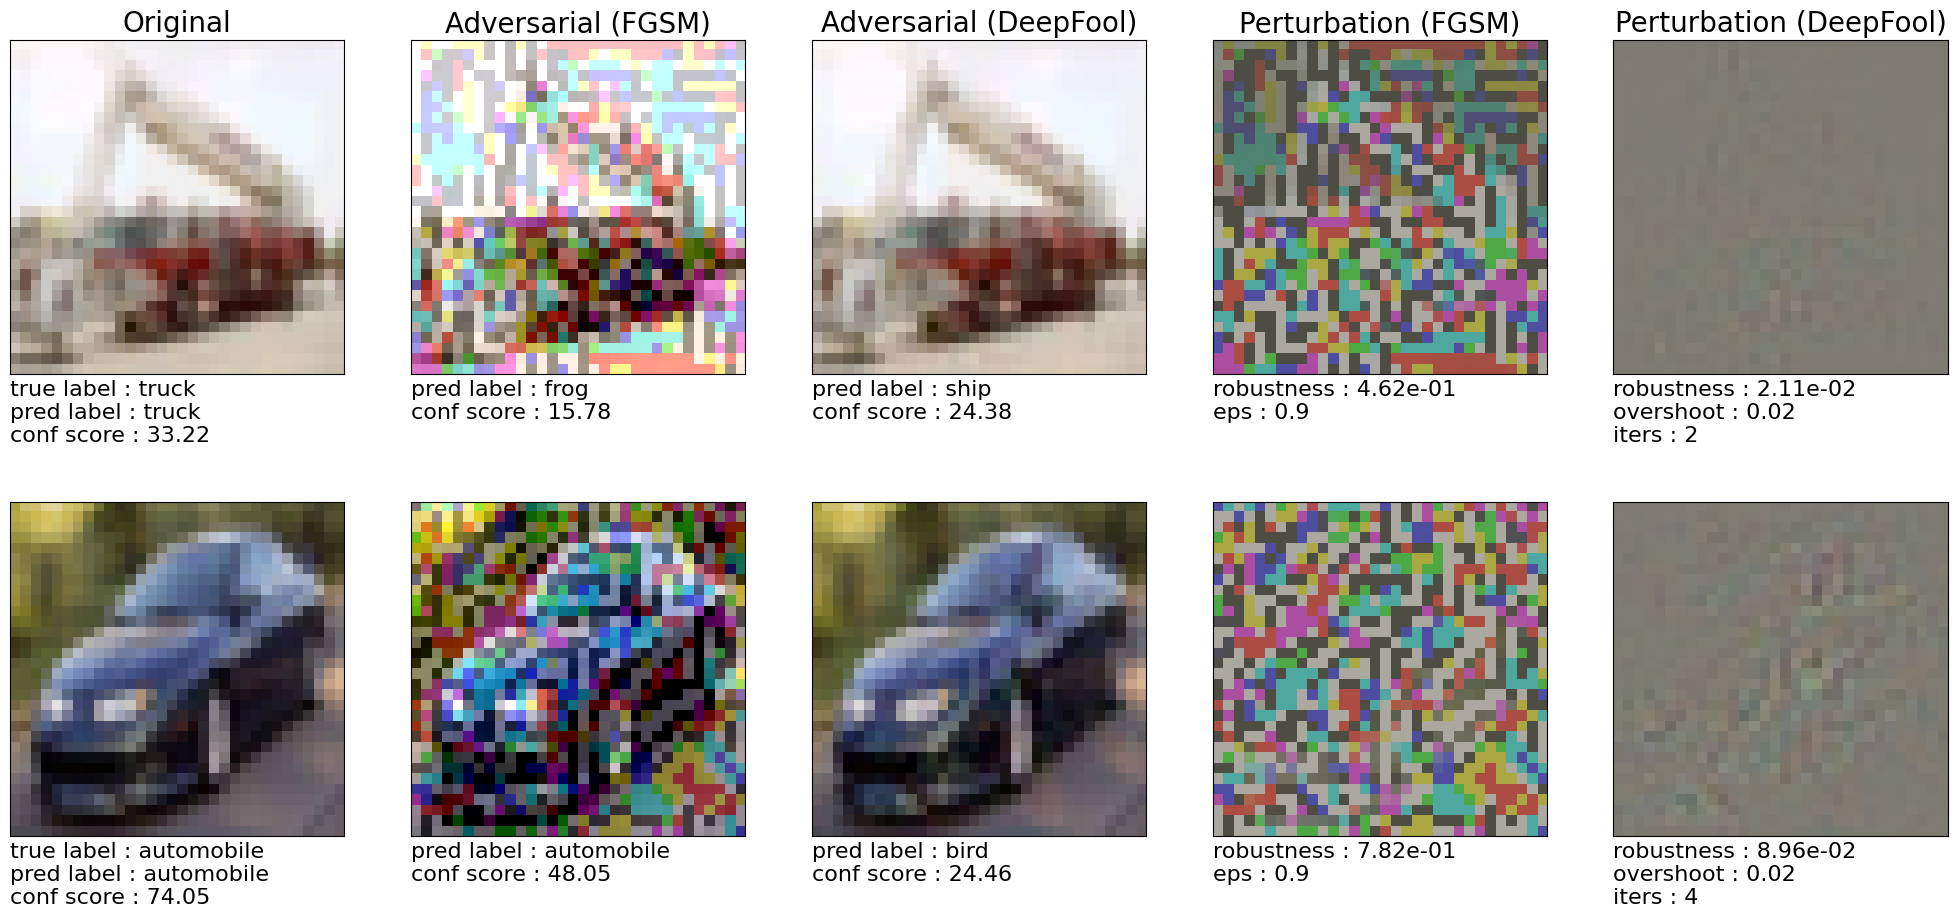

In [ ]:
fgsm_eps = 0.9
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-45-7371c6317613>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


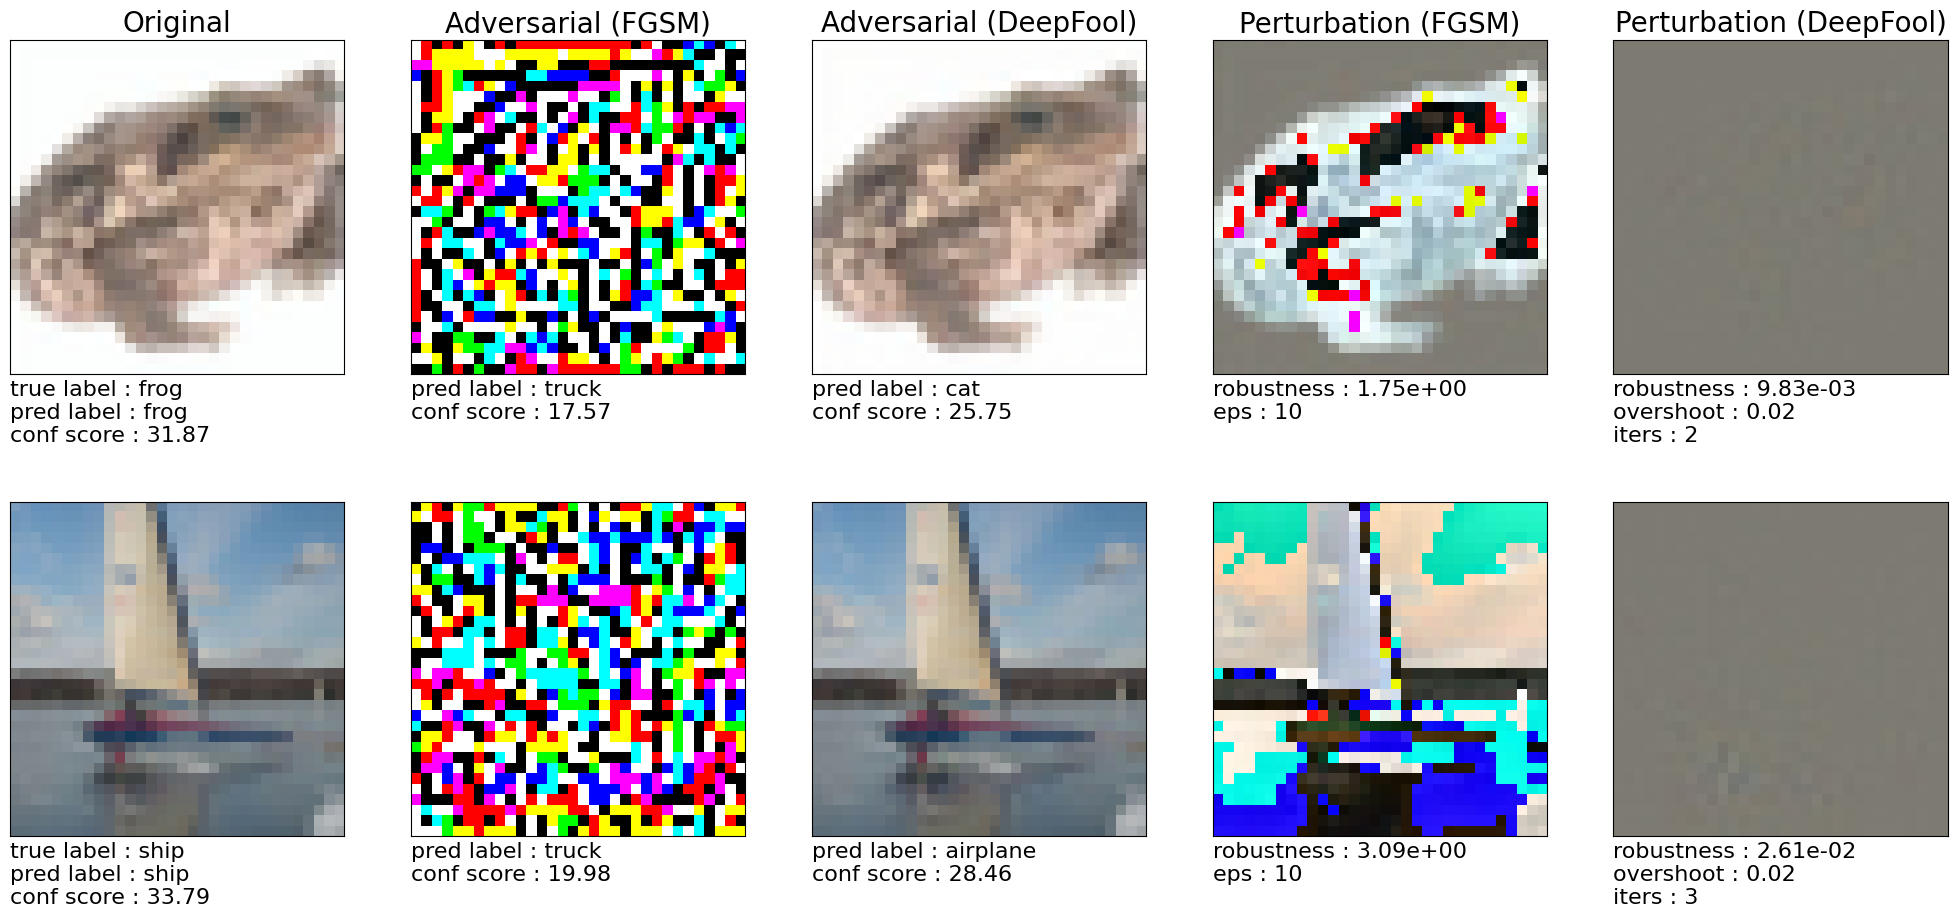

In [ ]:
fgsm_eps = 10
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-17-ce57b5d9ce5d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


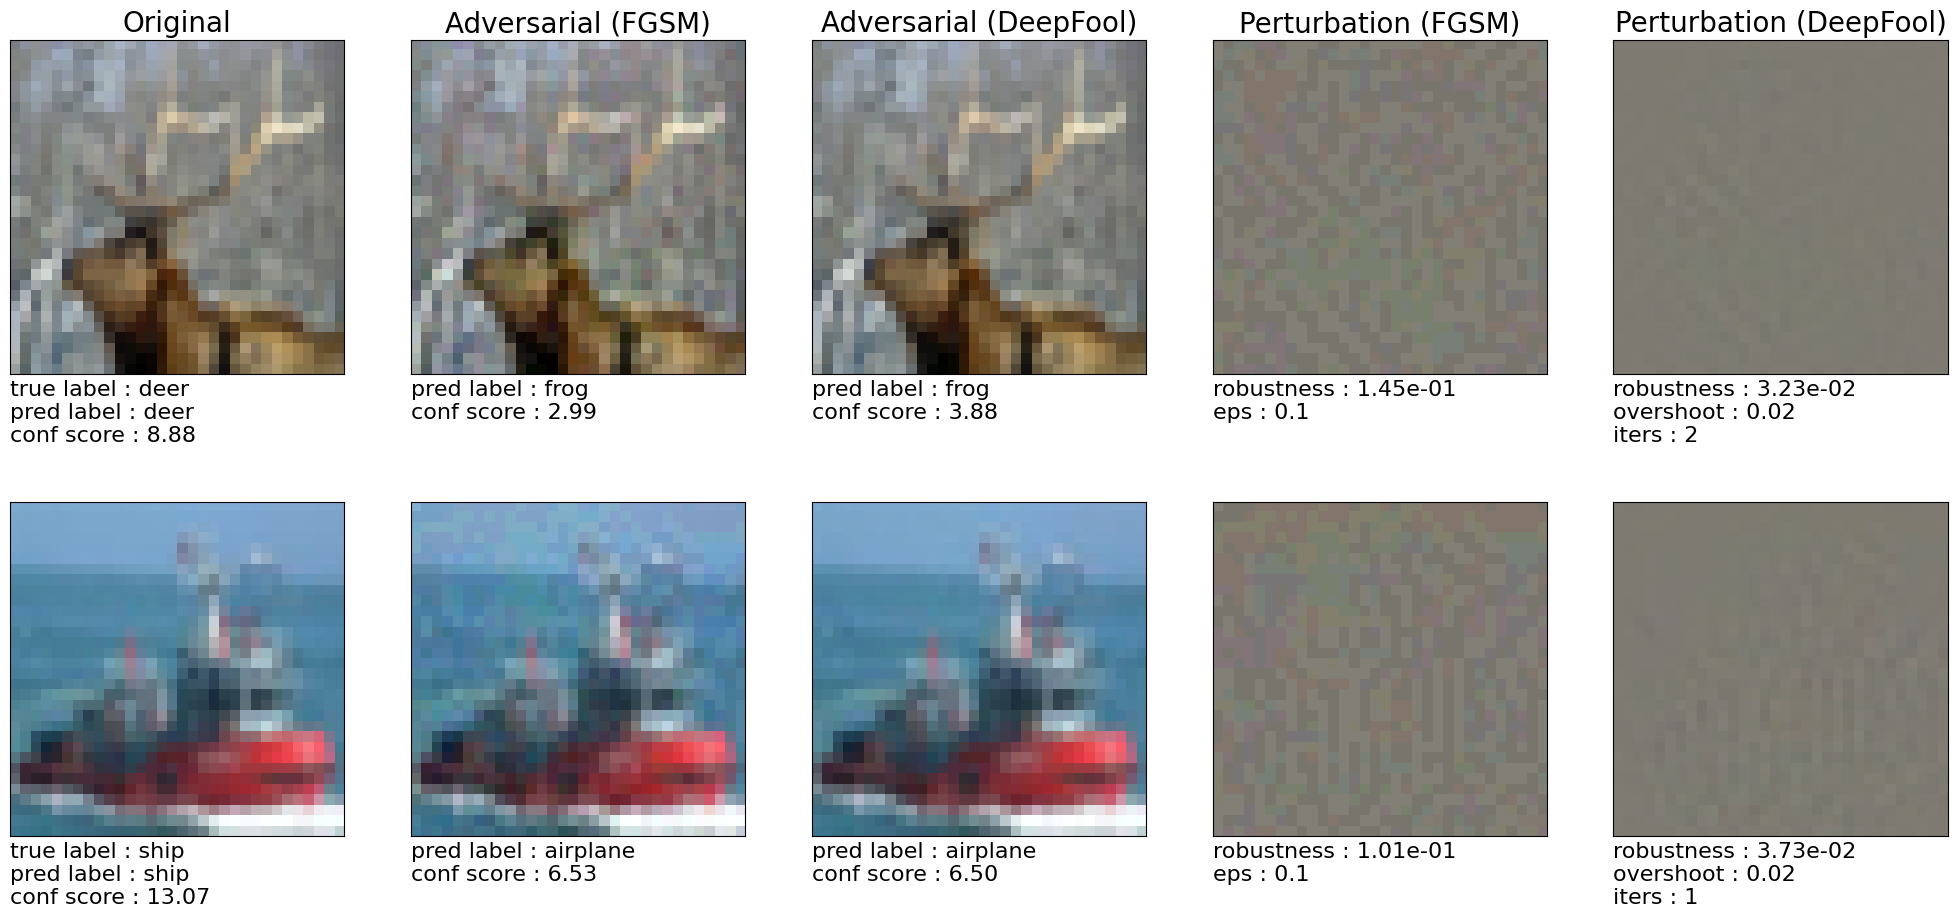

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-26-6904df18a1f4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


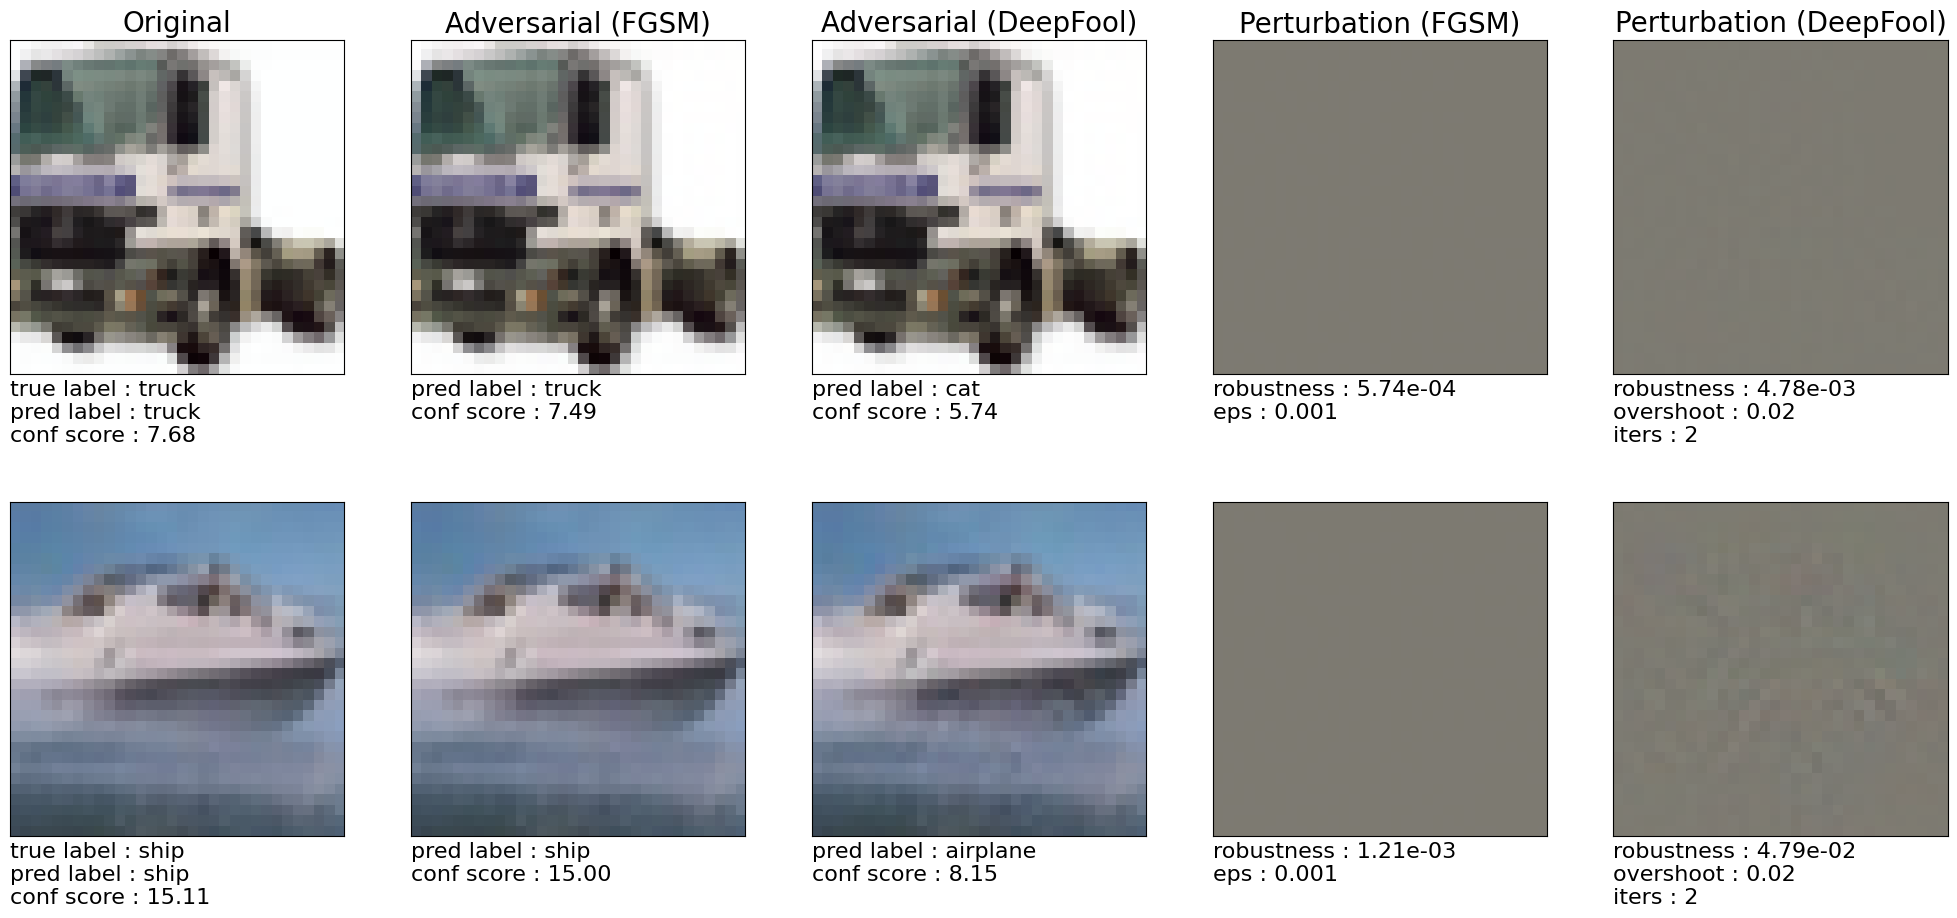

In [ ]:
fgsm_eps = 0.001
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-27-9163cae16ed1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


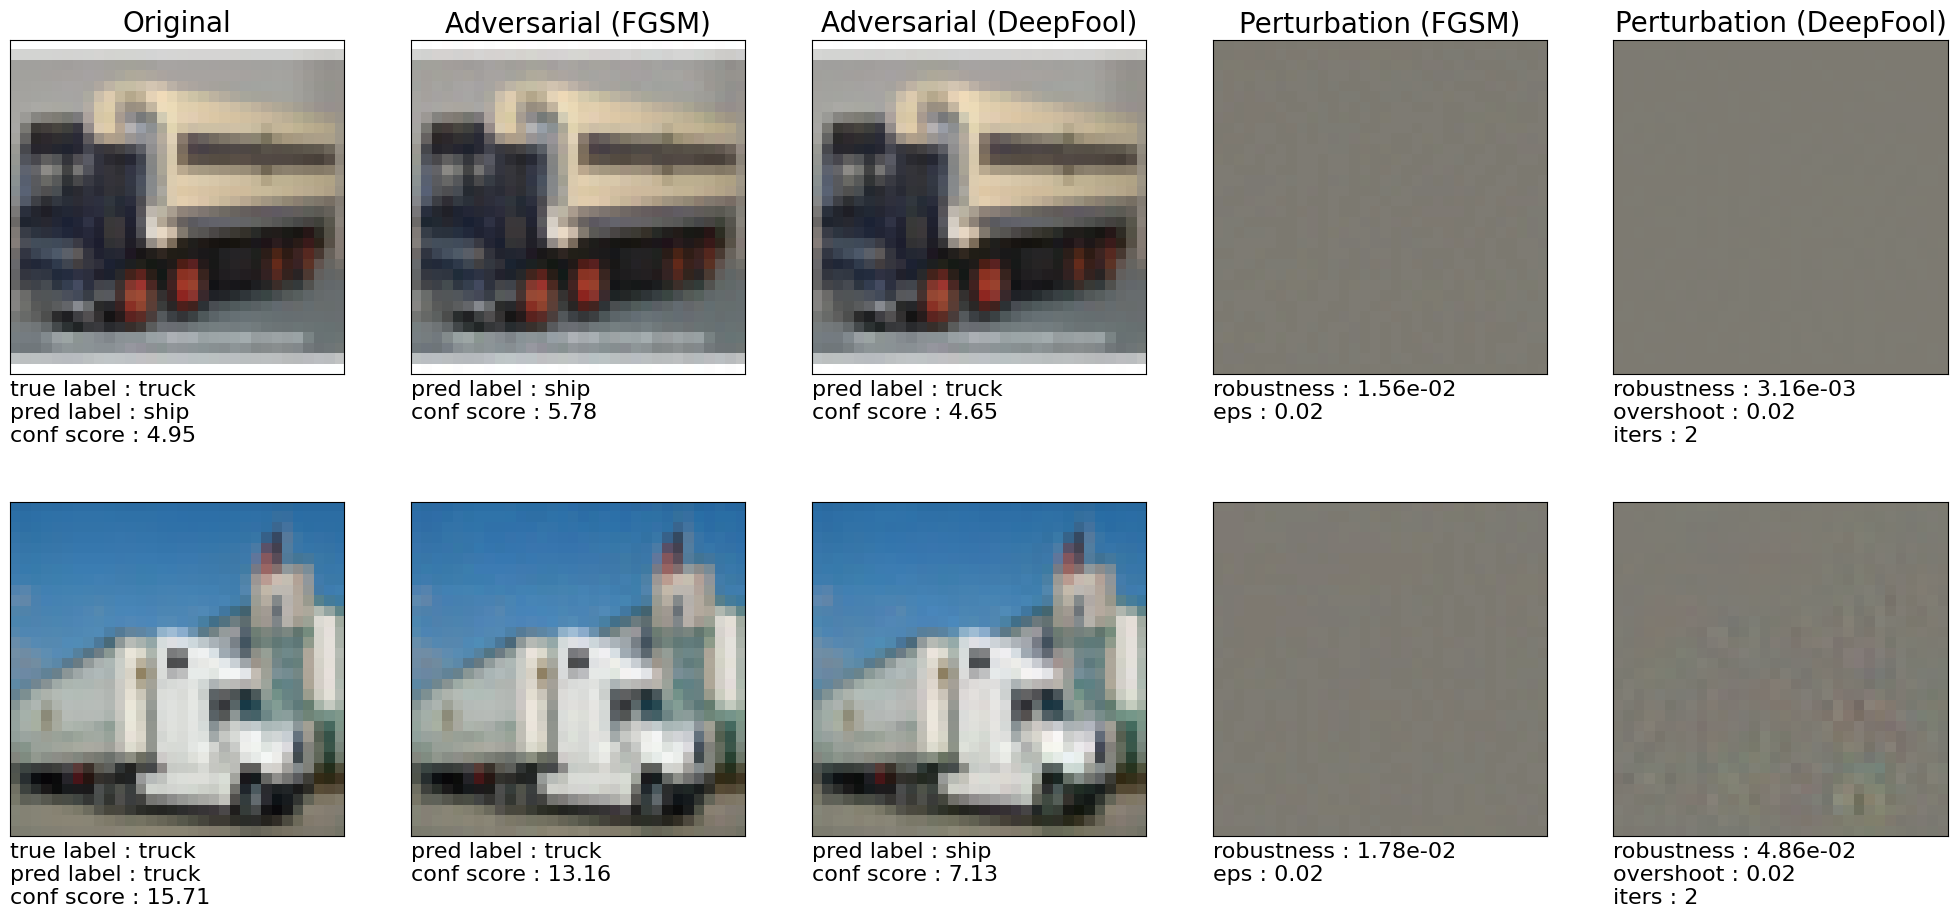

In [ ]:
fgsm_eps = 0.02
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-28-f0f2b55de884>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


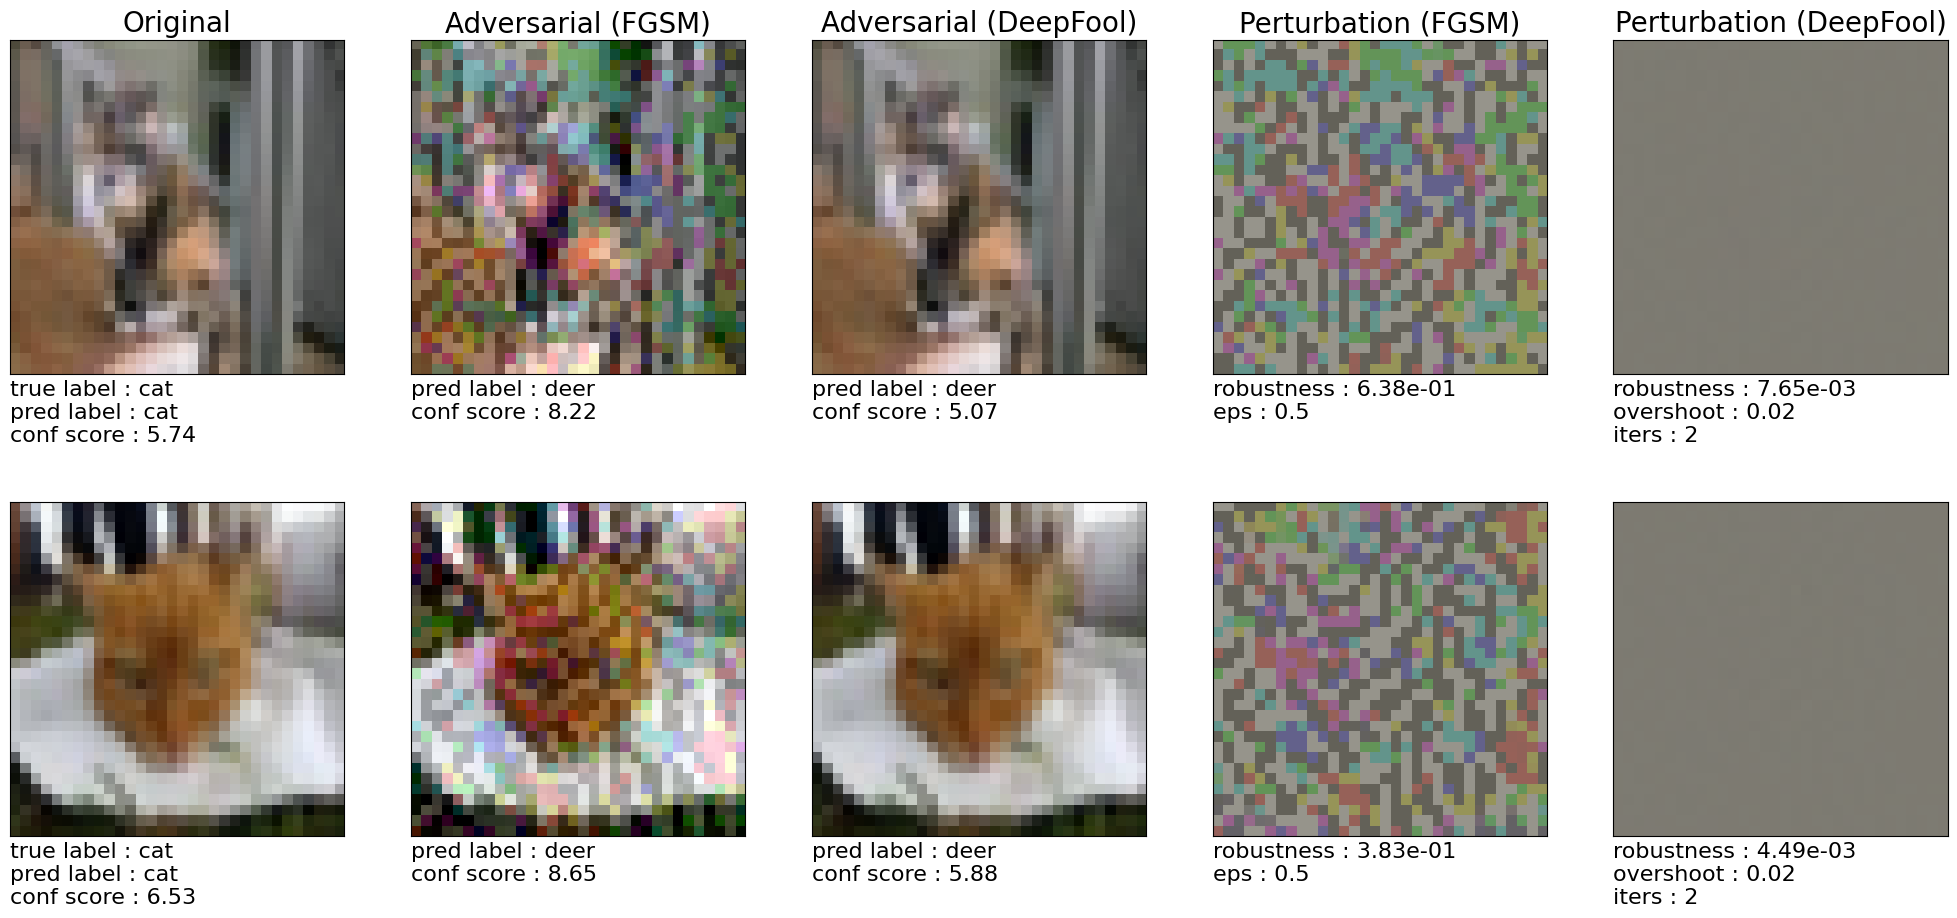

In [ ]:
fgsm_eps = 0.5
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-29-720da8f7f722>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


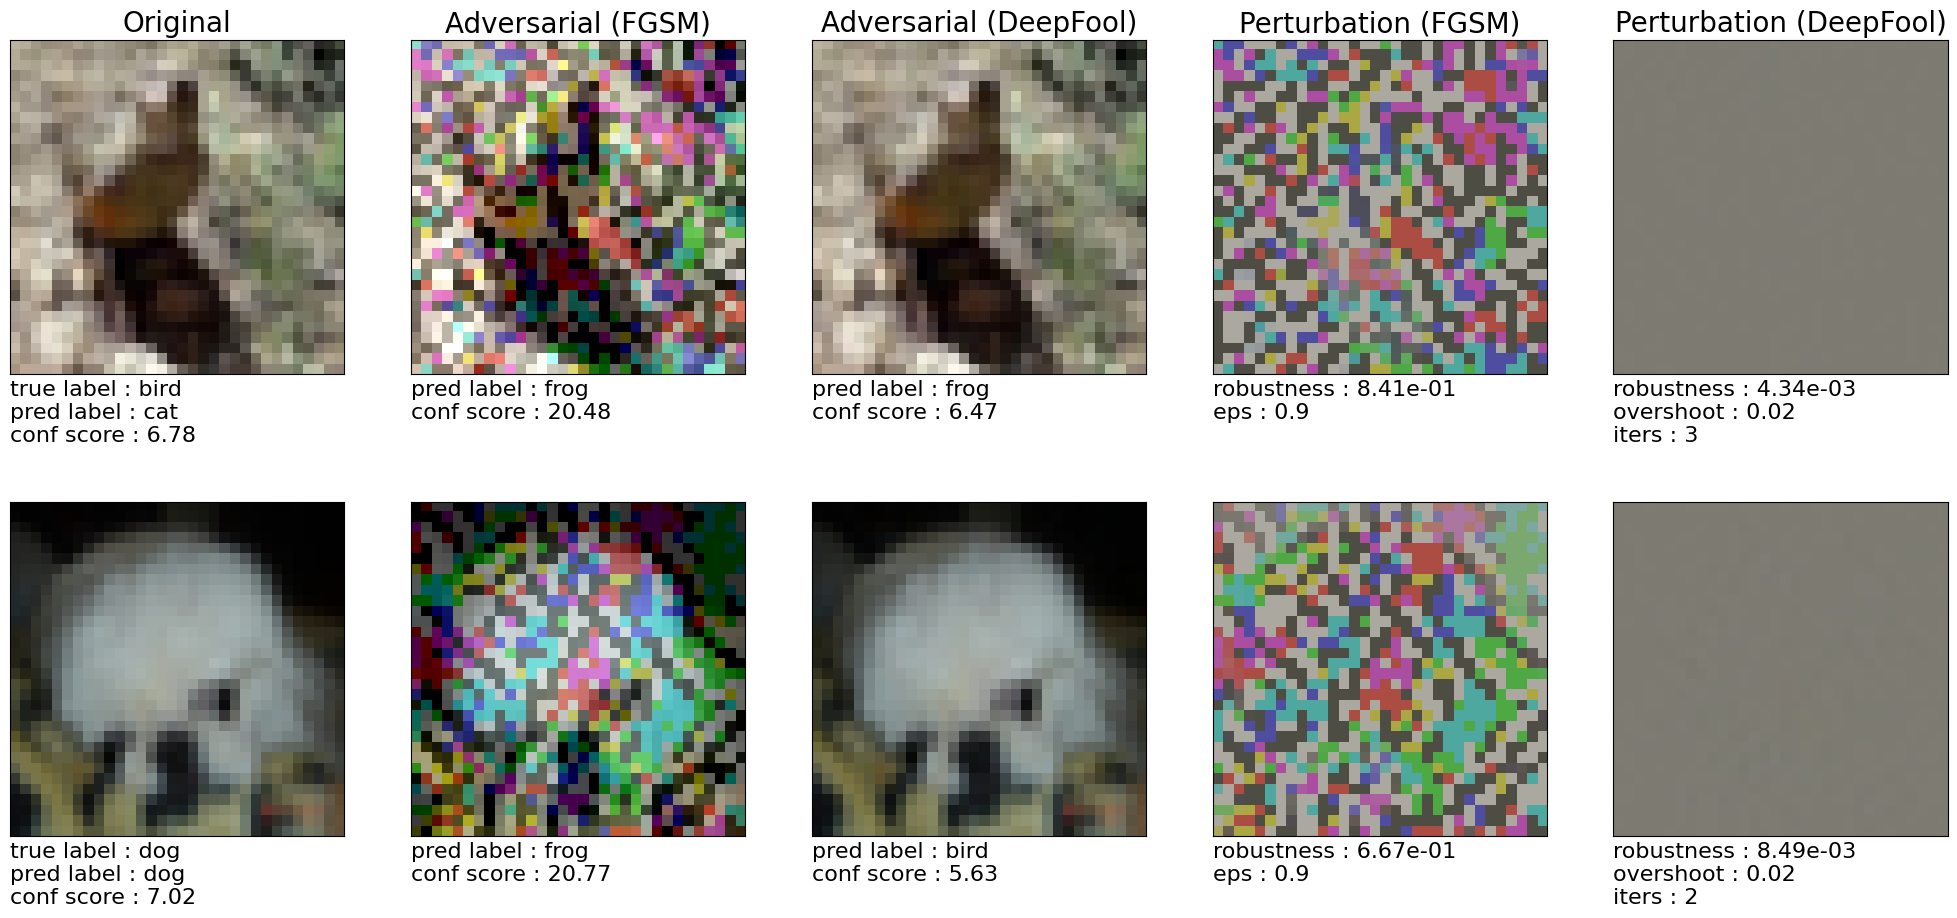

In [ ]:
fgsm_eps = 0.9
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-30-1ea482eca659>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


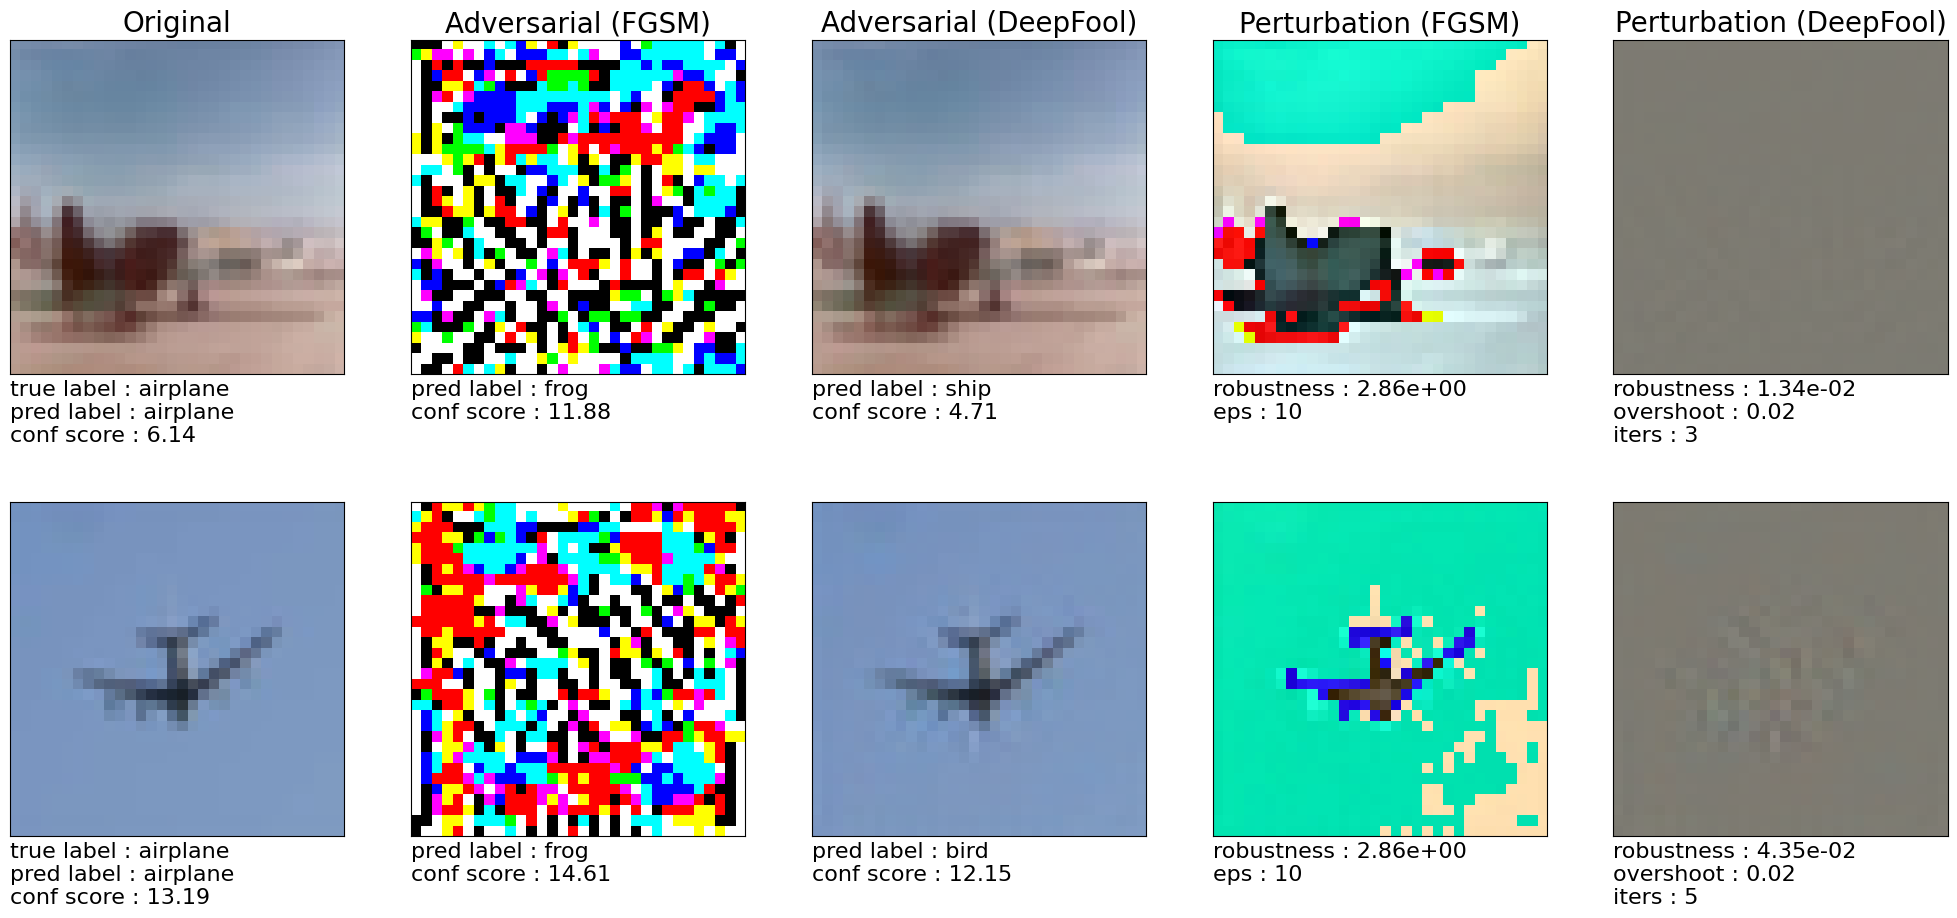

In [ ]:
fgsm_eps = 10
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()

<ipython-input-40-a0a54725abfb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


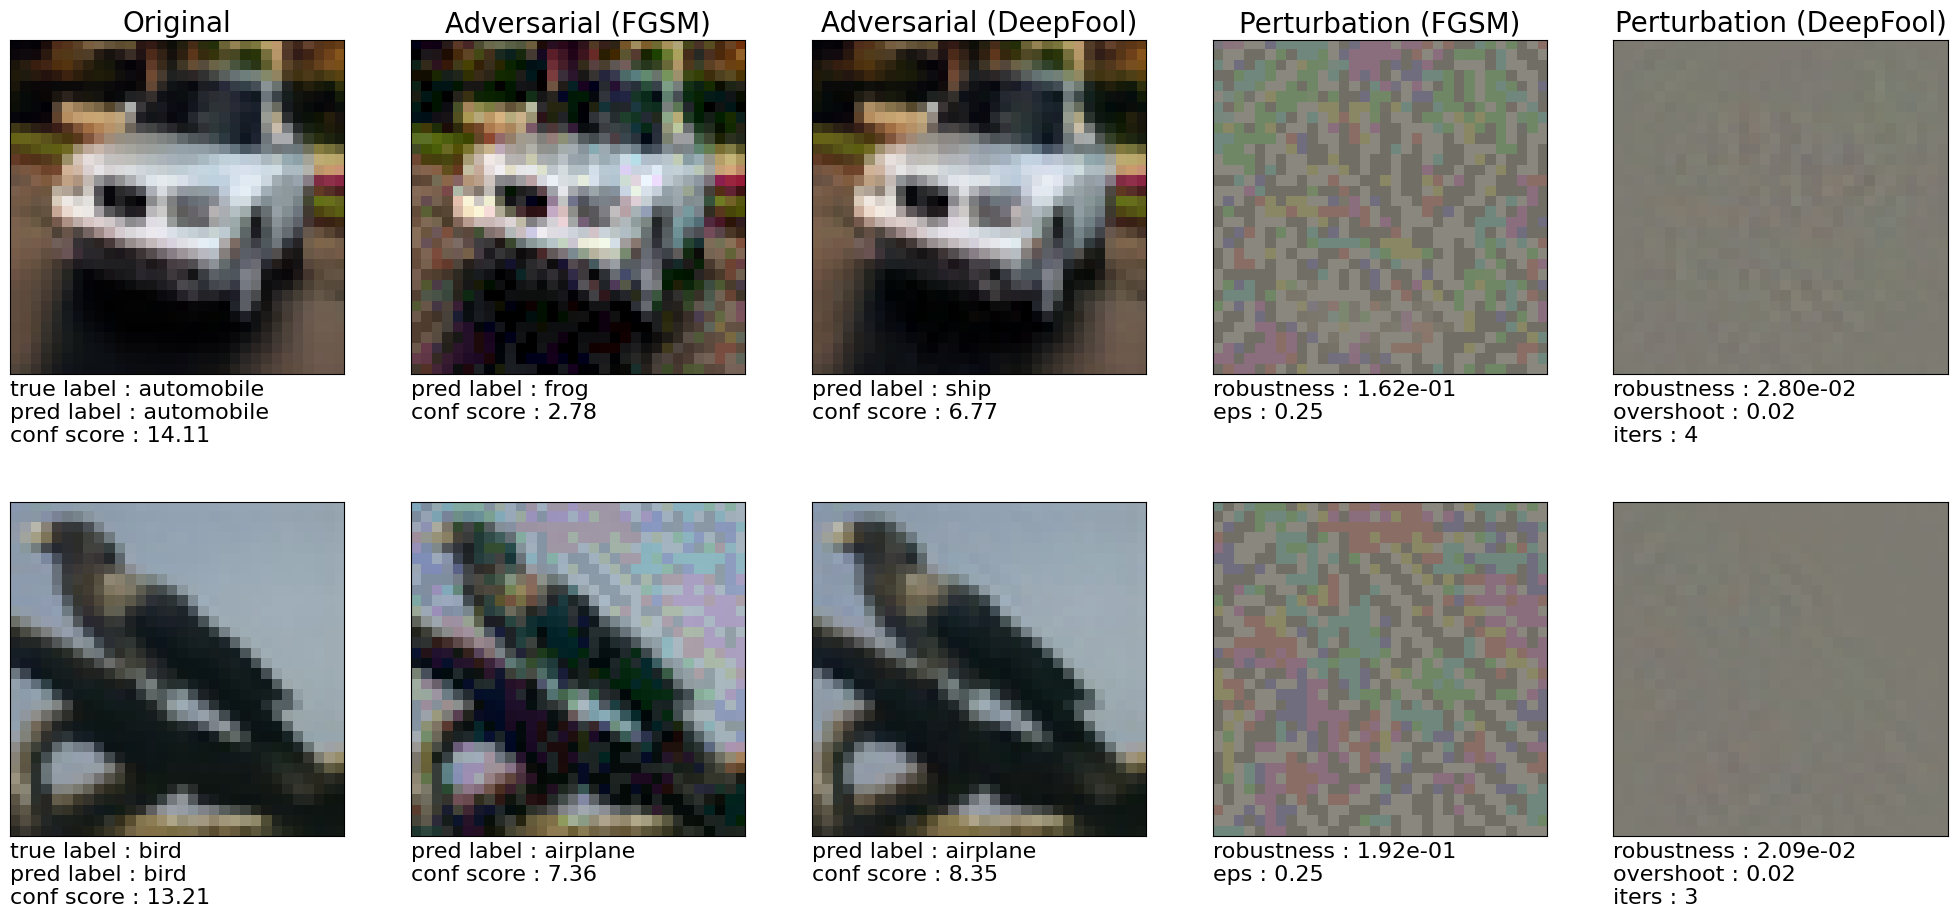

In [ ]:
fgsm_eps = 0.25
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv,
               cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0,
               fig_rows=2, fig_width=25, fig_height=11,
               label_map=cifar_classes)

if device.type == 'cuda':
    torch.cuda.empty_cache()